# Time Series Analysis of NVIDIA Stock Prices (1999-2025)


In [28]:
# Install required packages if needed
# install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
#                   "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
#                   "FinTS", "ggthemes"))


In [29]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(forecast)
  library(tseries)
  library(dplyr)
  library(lubridate)
  library(gridExtra)
  library(MASS)
  library(knitr)
  library(lawstat)
  library(FinTS)
  library(TSA)
})


In [30]:
# Plot settings
options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}


In [31]:
# loading the data and checking it for missing values
# and summary statistics, then printing the results

nvidia_df <- read.csv("../data/nvidia_close_price.csv")

nvidia_df$Date <- as.Date(nvidia_df$Date)

cat("Dataset summary:\n")
print(summary(nvidia_df))

cat(
    "\nDate range:", format(min(nvidia_df$Date), "%Y-%m-%d"),
    "to", format(max(nvidia_df$Date), "%Y-%m-%d"), "\n"
)

cat(
    "Price range:", min(nvidia_df$Price),
    "to", max(nvidia_df$Price), "USD\n"
)

missing_values <- colSums(is.na(nvidia_df))
cat("\nMissing values by column:\n")
print(missing_values)


Dataset summary:
      Date                Price          
 Min.   :1999-01-22   Min.   :  0.03128  
 1st Qu.:2005-08-09   1st Qu.:  0.25882  
 Median :2012-02-22   Median :  0.43829  
 Mean   :2012-02-22   Mean   :  9.24397  
 3rd Qu.:2018-09-06   3rd Qu.:  4.71775  
 Max.   :2025-03-27   Max.   :149.41624  

Date range: 1999-01-22 to 2025-03-27 
Price range: 0.03128349 to 149.4162 USD

Missing values by column:
 Date Price 
    0     0 


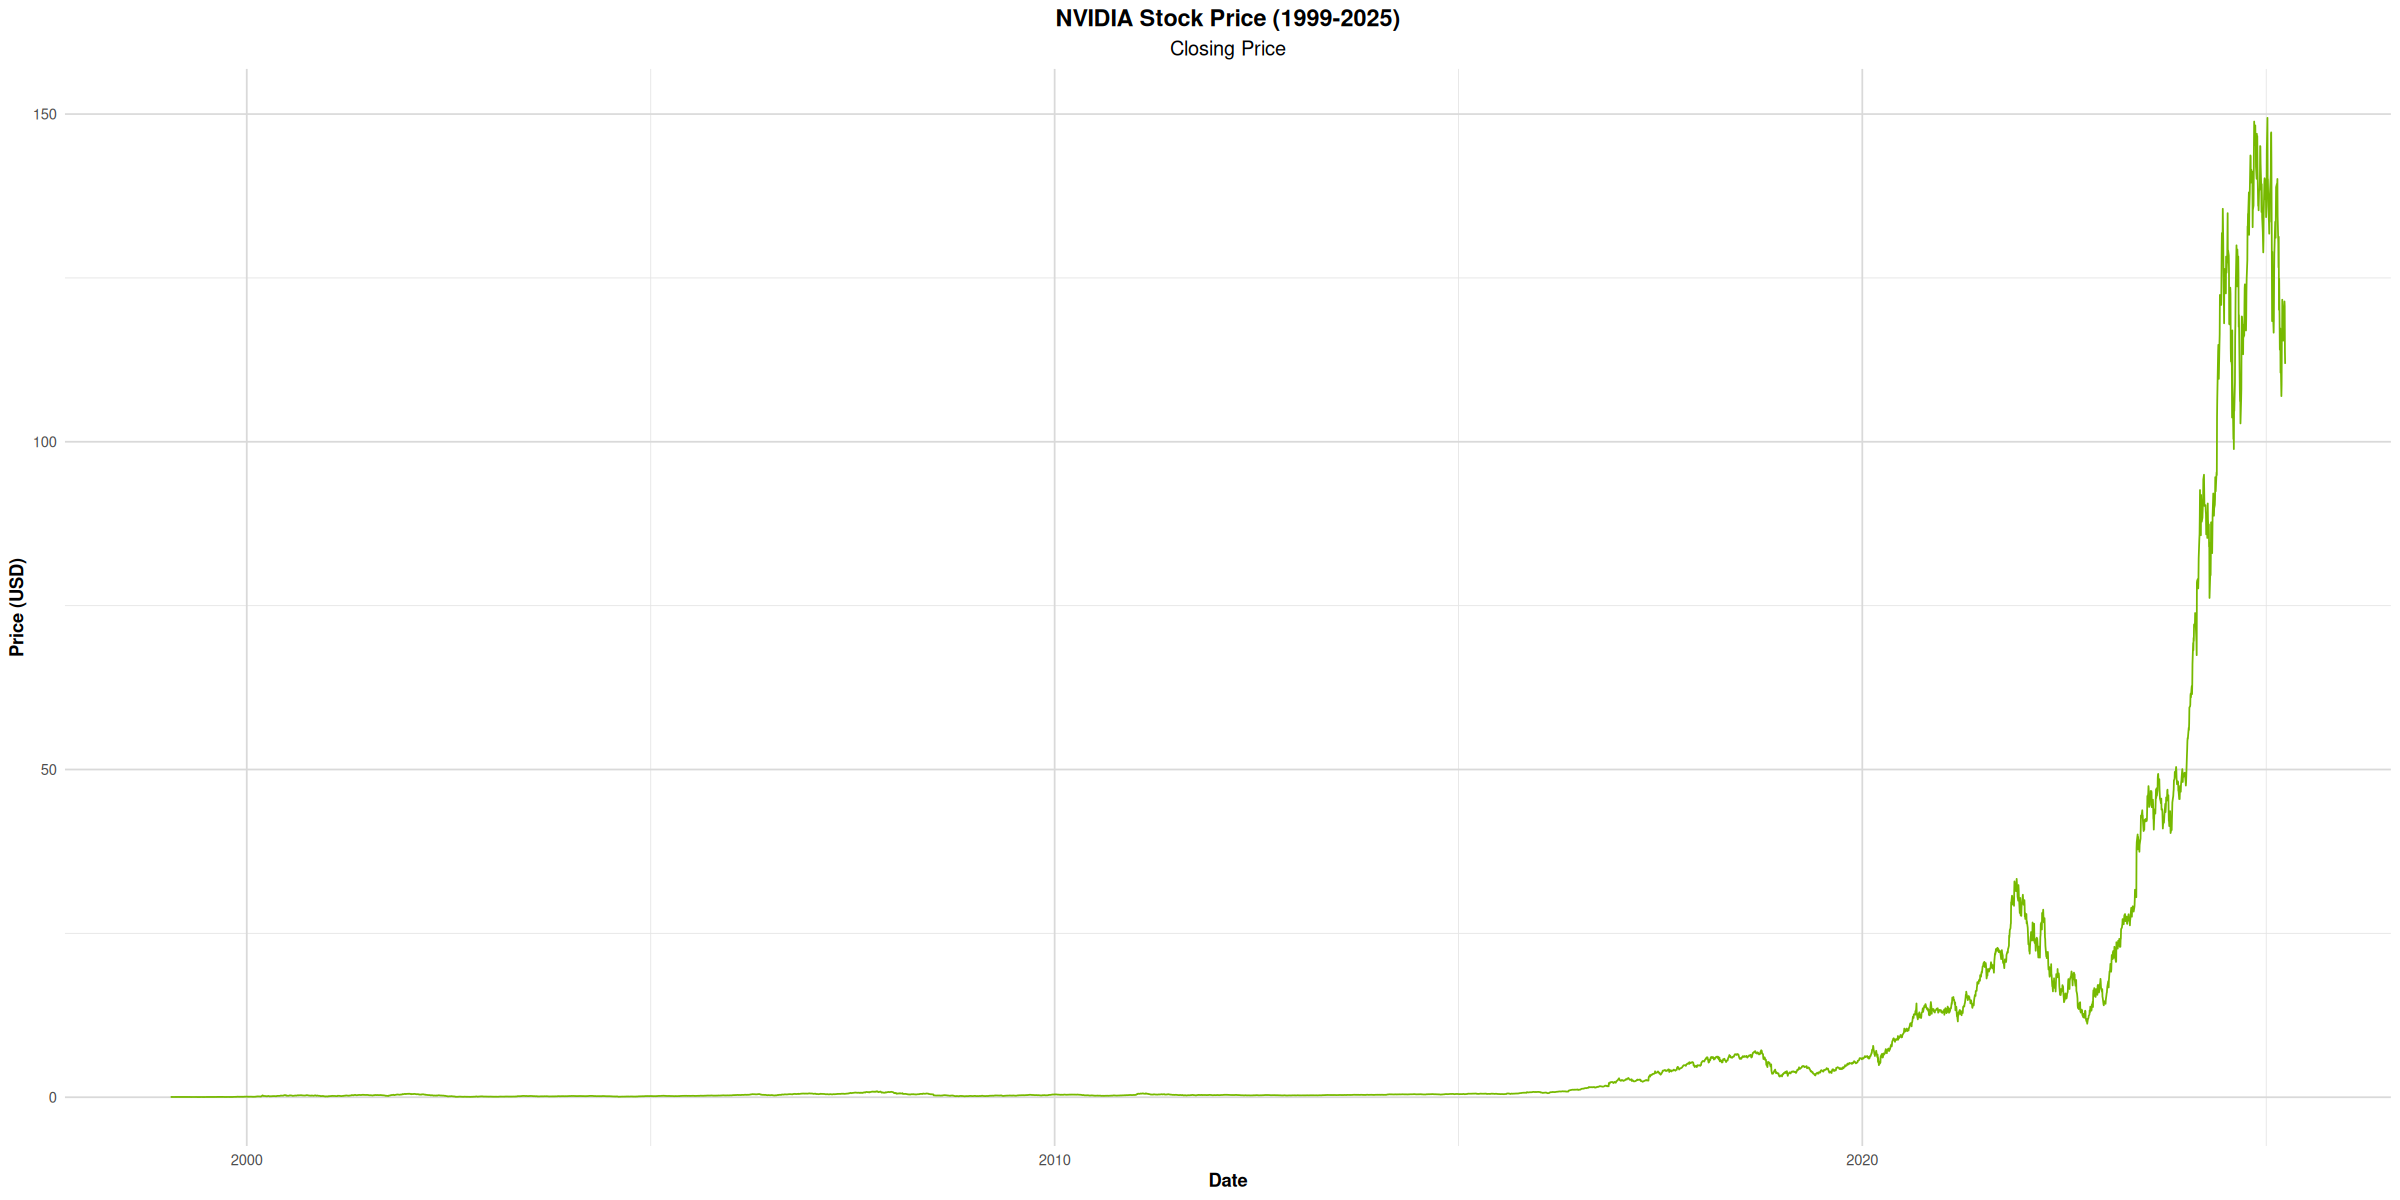

In [32]:
# plot the series

p1 <- ggplot(nvidia_df, aes(x = Date, y = Price)) +
  geom_line(color = "#76B900") +
  labs(
    title = "NVIDIA Stock Price (1999-2025)",
    subtitle = "Closing Price",
    x = "Date",
    y = "Price (USD)"
  ) +
  theme_tsa()

print(p1)


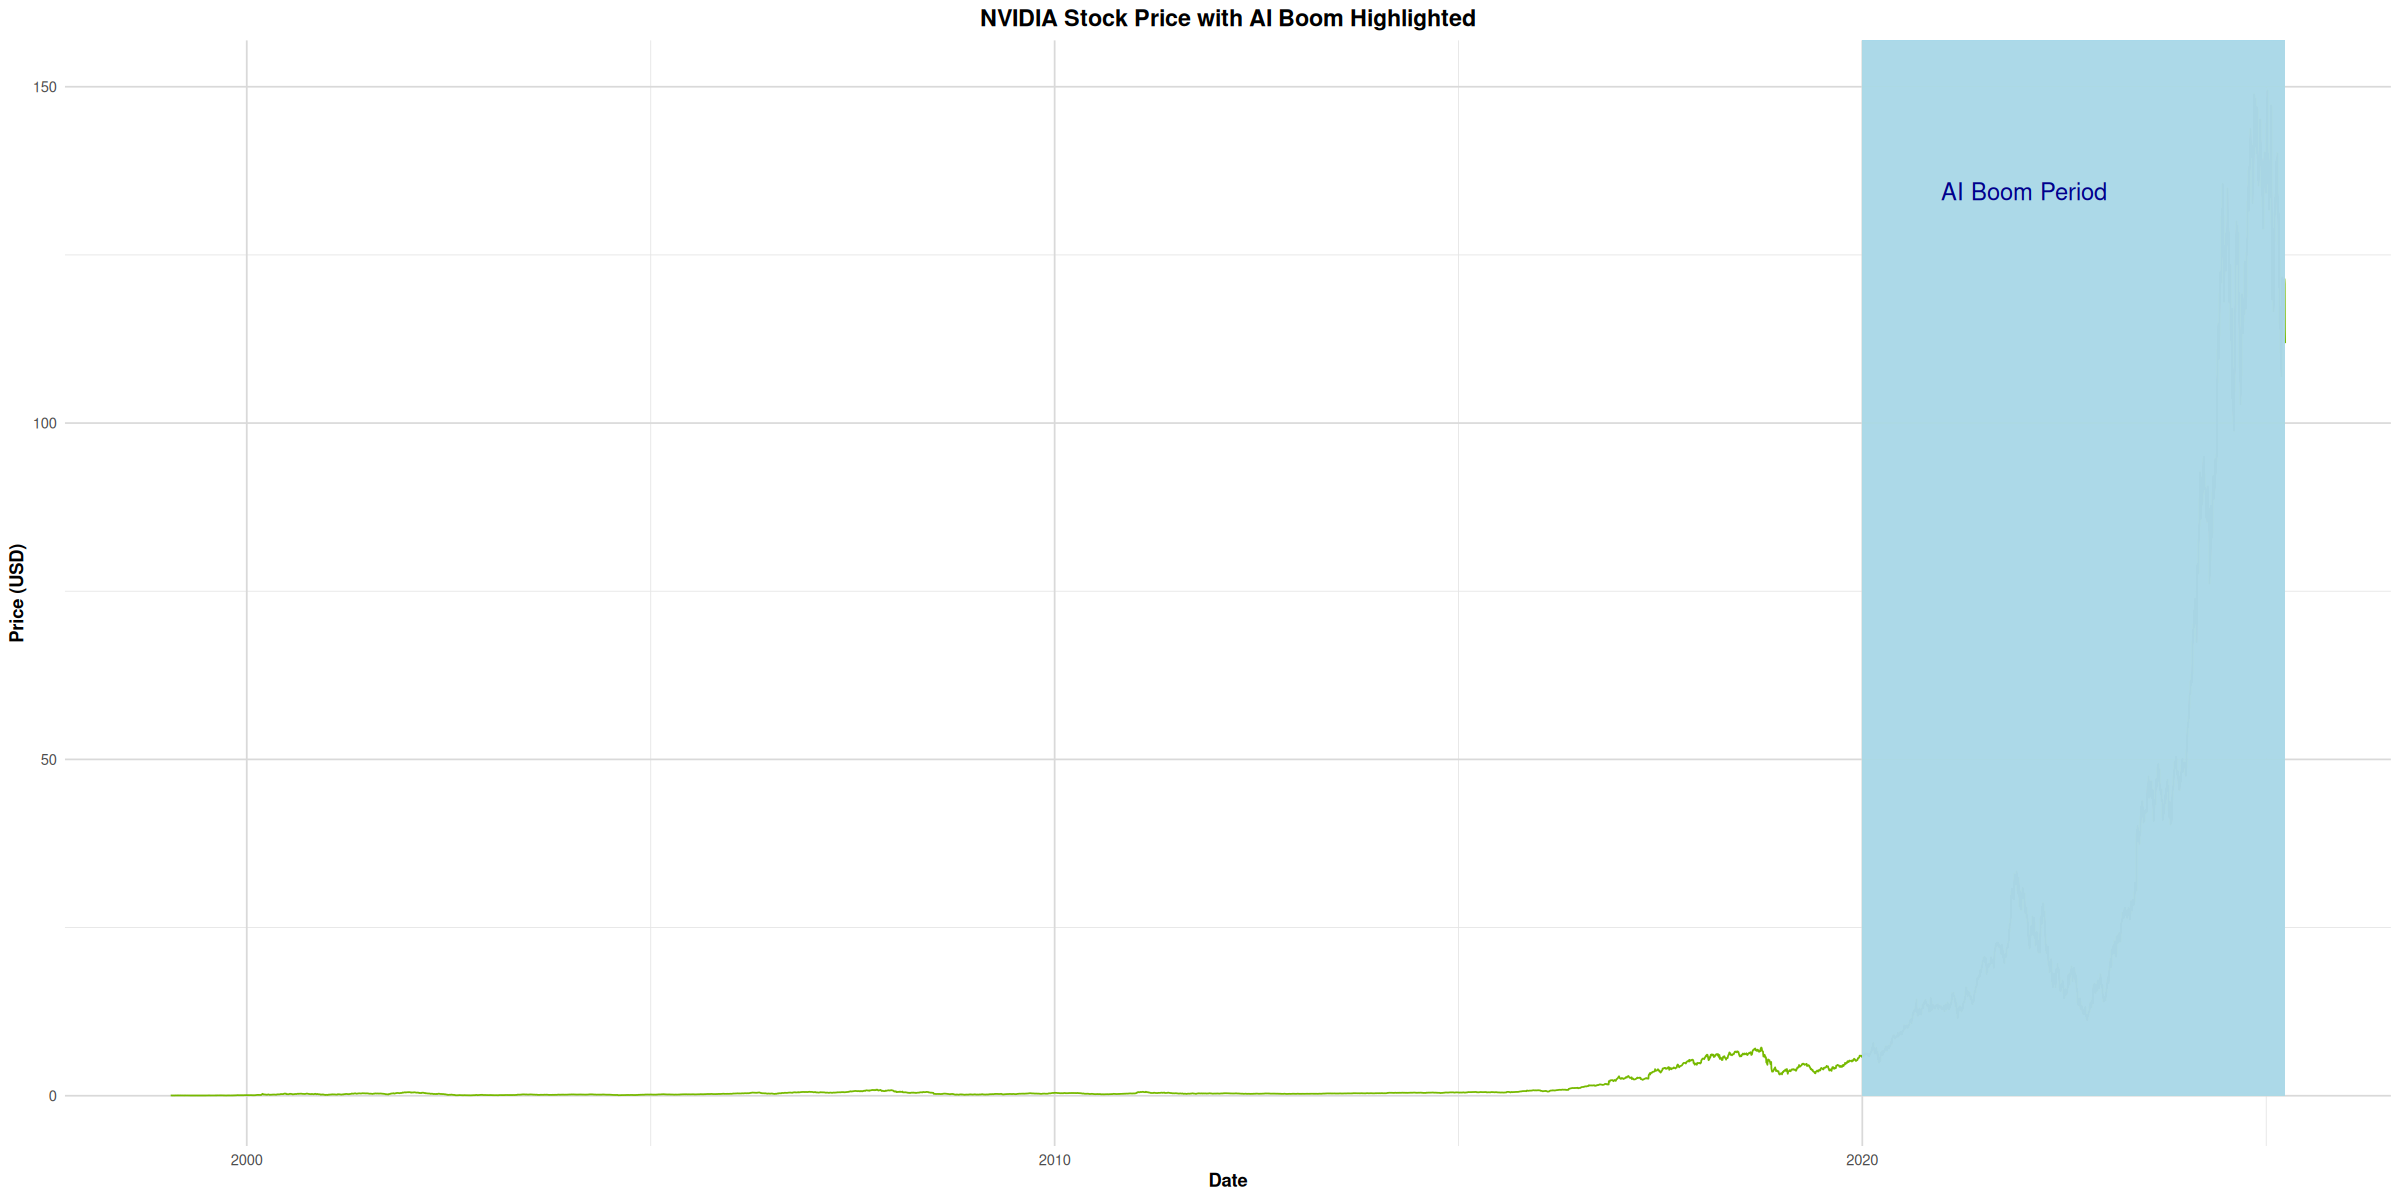

In [33]:
p2 <- ggplot(nvidia_df, aes(x = Date, y = Price)) +
  geom_line(color = "#76B900") +
  geom_rect(
    aes(
      xmin = as.Date("2020-01-01"),
      xmax = max(Date),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightblue", alpha = 0.2
  ) +
  annotate("text",
    x = as.Date("2022-01-01"), y = max(nvidia_df$Price) * 0.9,
    label = "AI Boom Period", color = "darkblue", size = 5
  ) +
  labs(
    title = "NVIDIA Stock Price with AI Boom Highlighted",
    x = "Date",
    y = "Price (USD)"
  ) +
  theme_tsa()

print(p2)


In [34]:
# extracting monthly data for easier analysis
# and create a time series object
nvidia_df$YearMonth <- format(nvidia_df$Date, "%Y-%m")

monthly_data <- nvidia_df %>%
  group_by(YearMonth) %>%
  summarize(
    Date = last(Date),
    Price = last(Price)
  ) %>%
  arrange(Date)

monthly_ts <- ts(monthly_data$Price,
  frequency = 12,
  start = c(
    year(min(monthly_data$Date)),
    month(min(monthly_data$Date))
  )
)


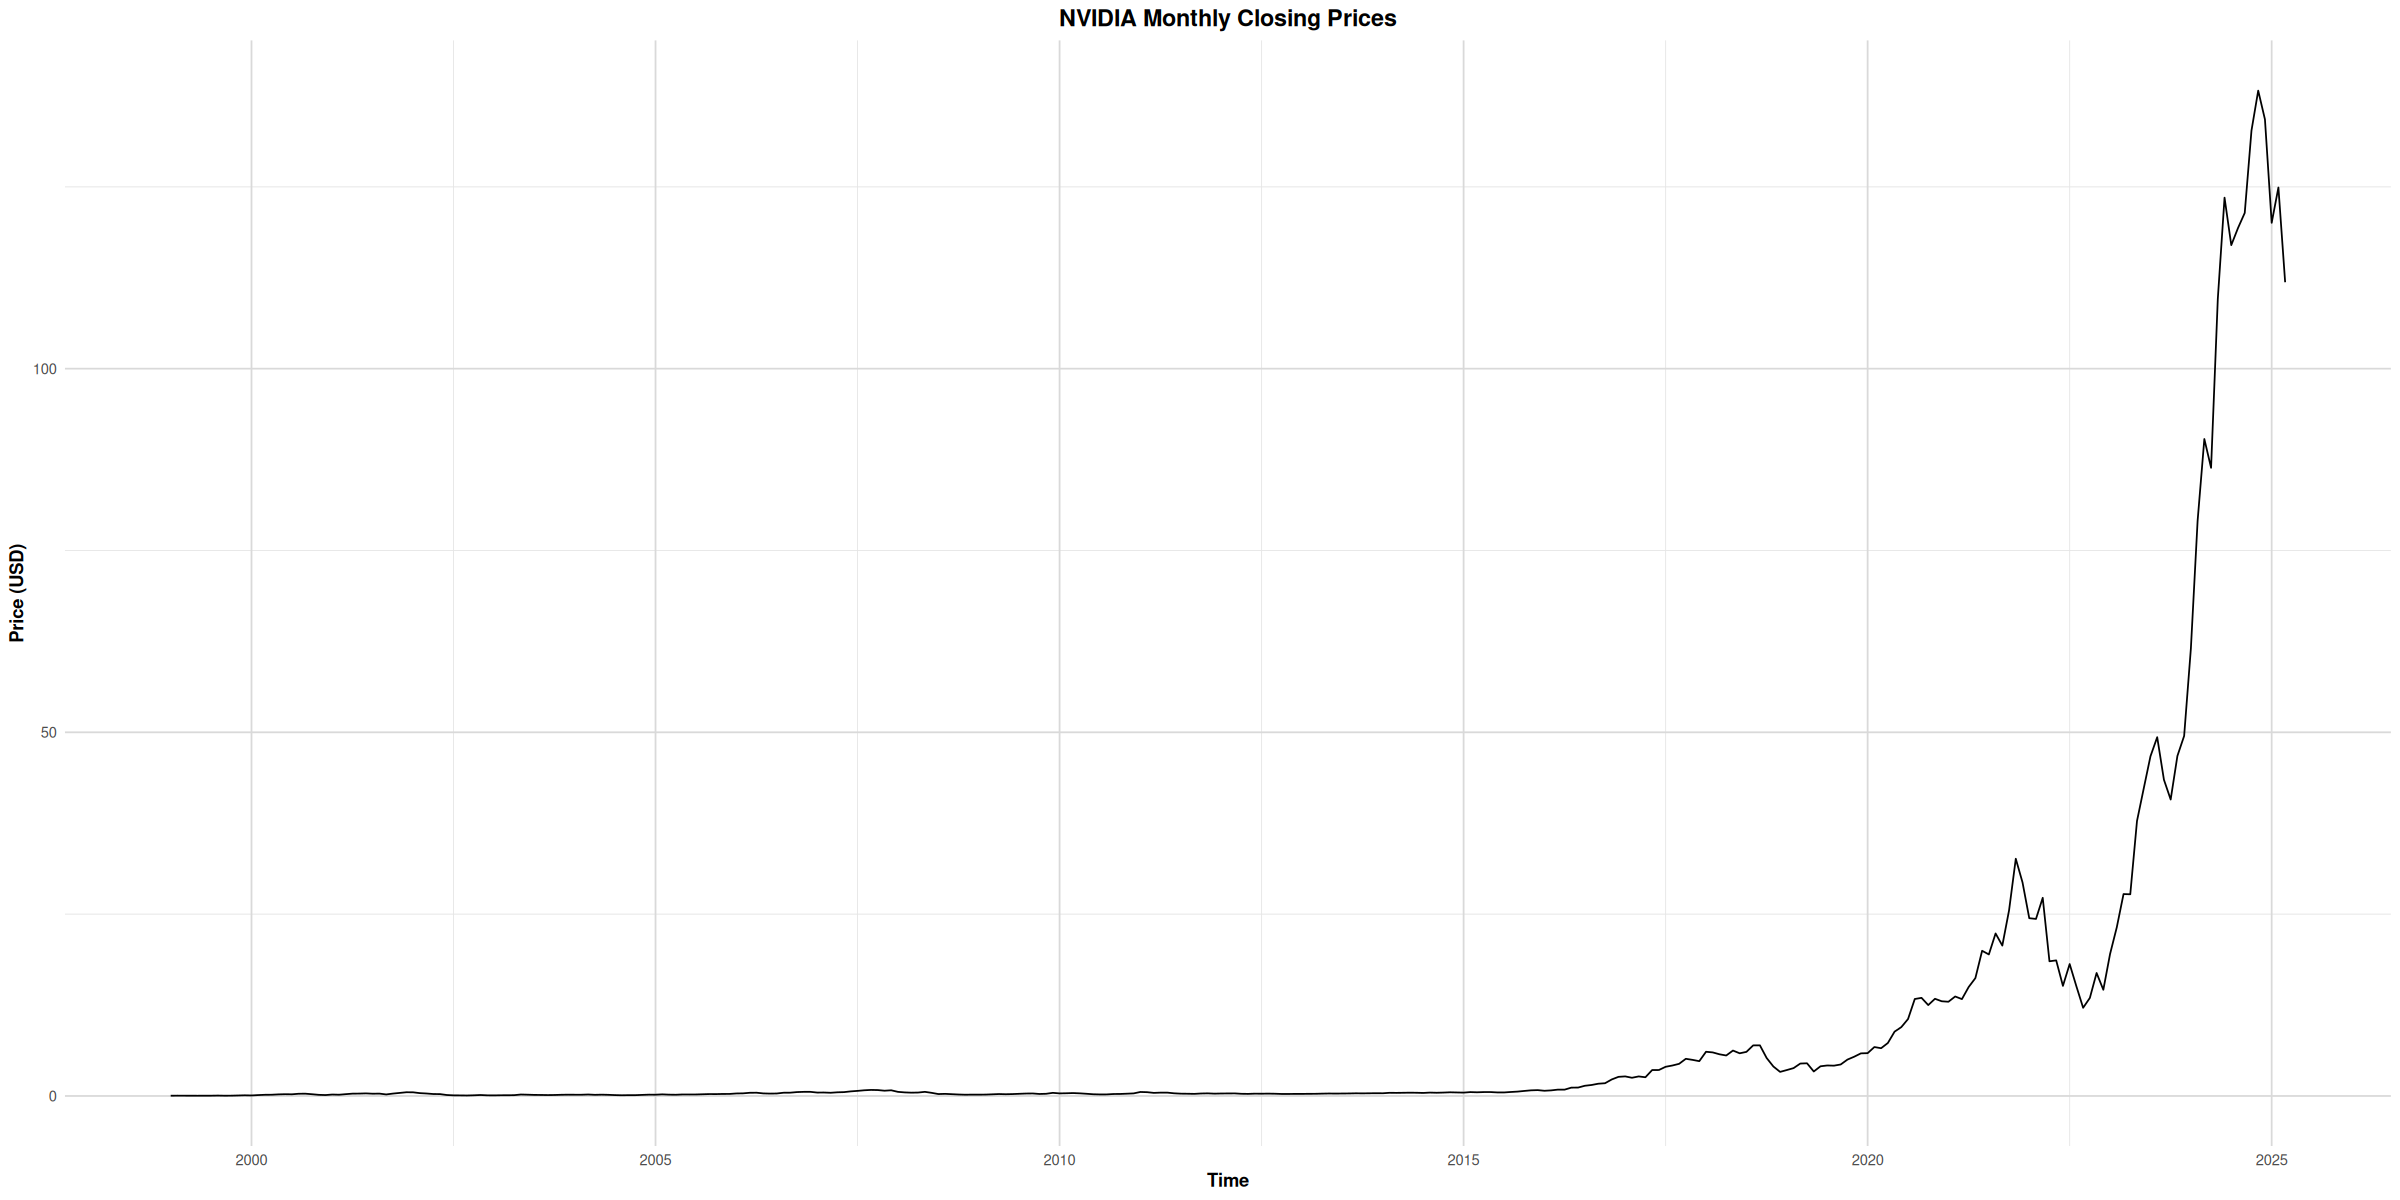

In [35]:
# plot the monthly series

autoplot(monthly_ts) +
  labs(
    title = "NVIDIA Monthly Closing Prices",
    x = "Time",
    y = "Price (USD)"
  ) +
  theme_tsa()


Optimal lambda for Box-Cox transformation: 0.08811436 
Lambda is close to 0, using log transformation


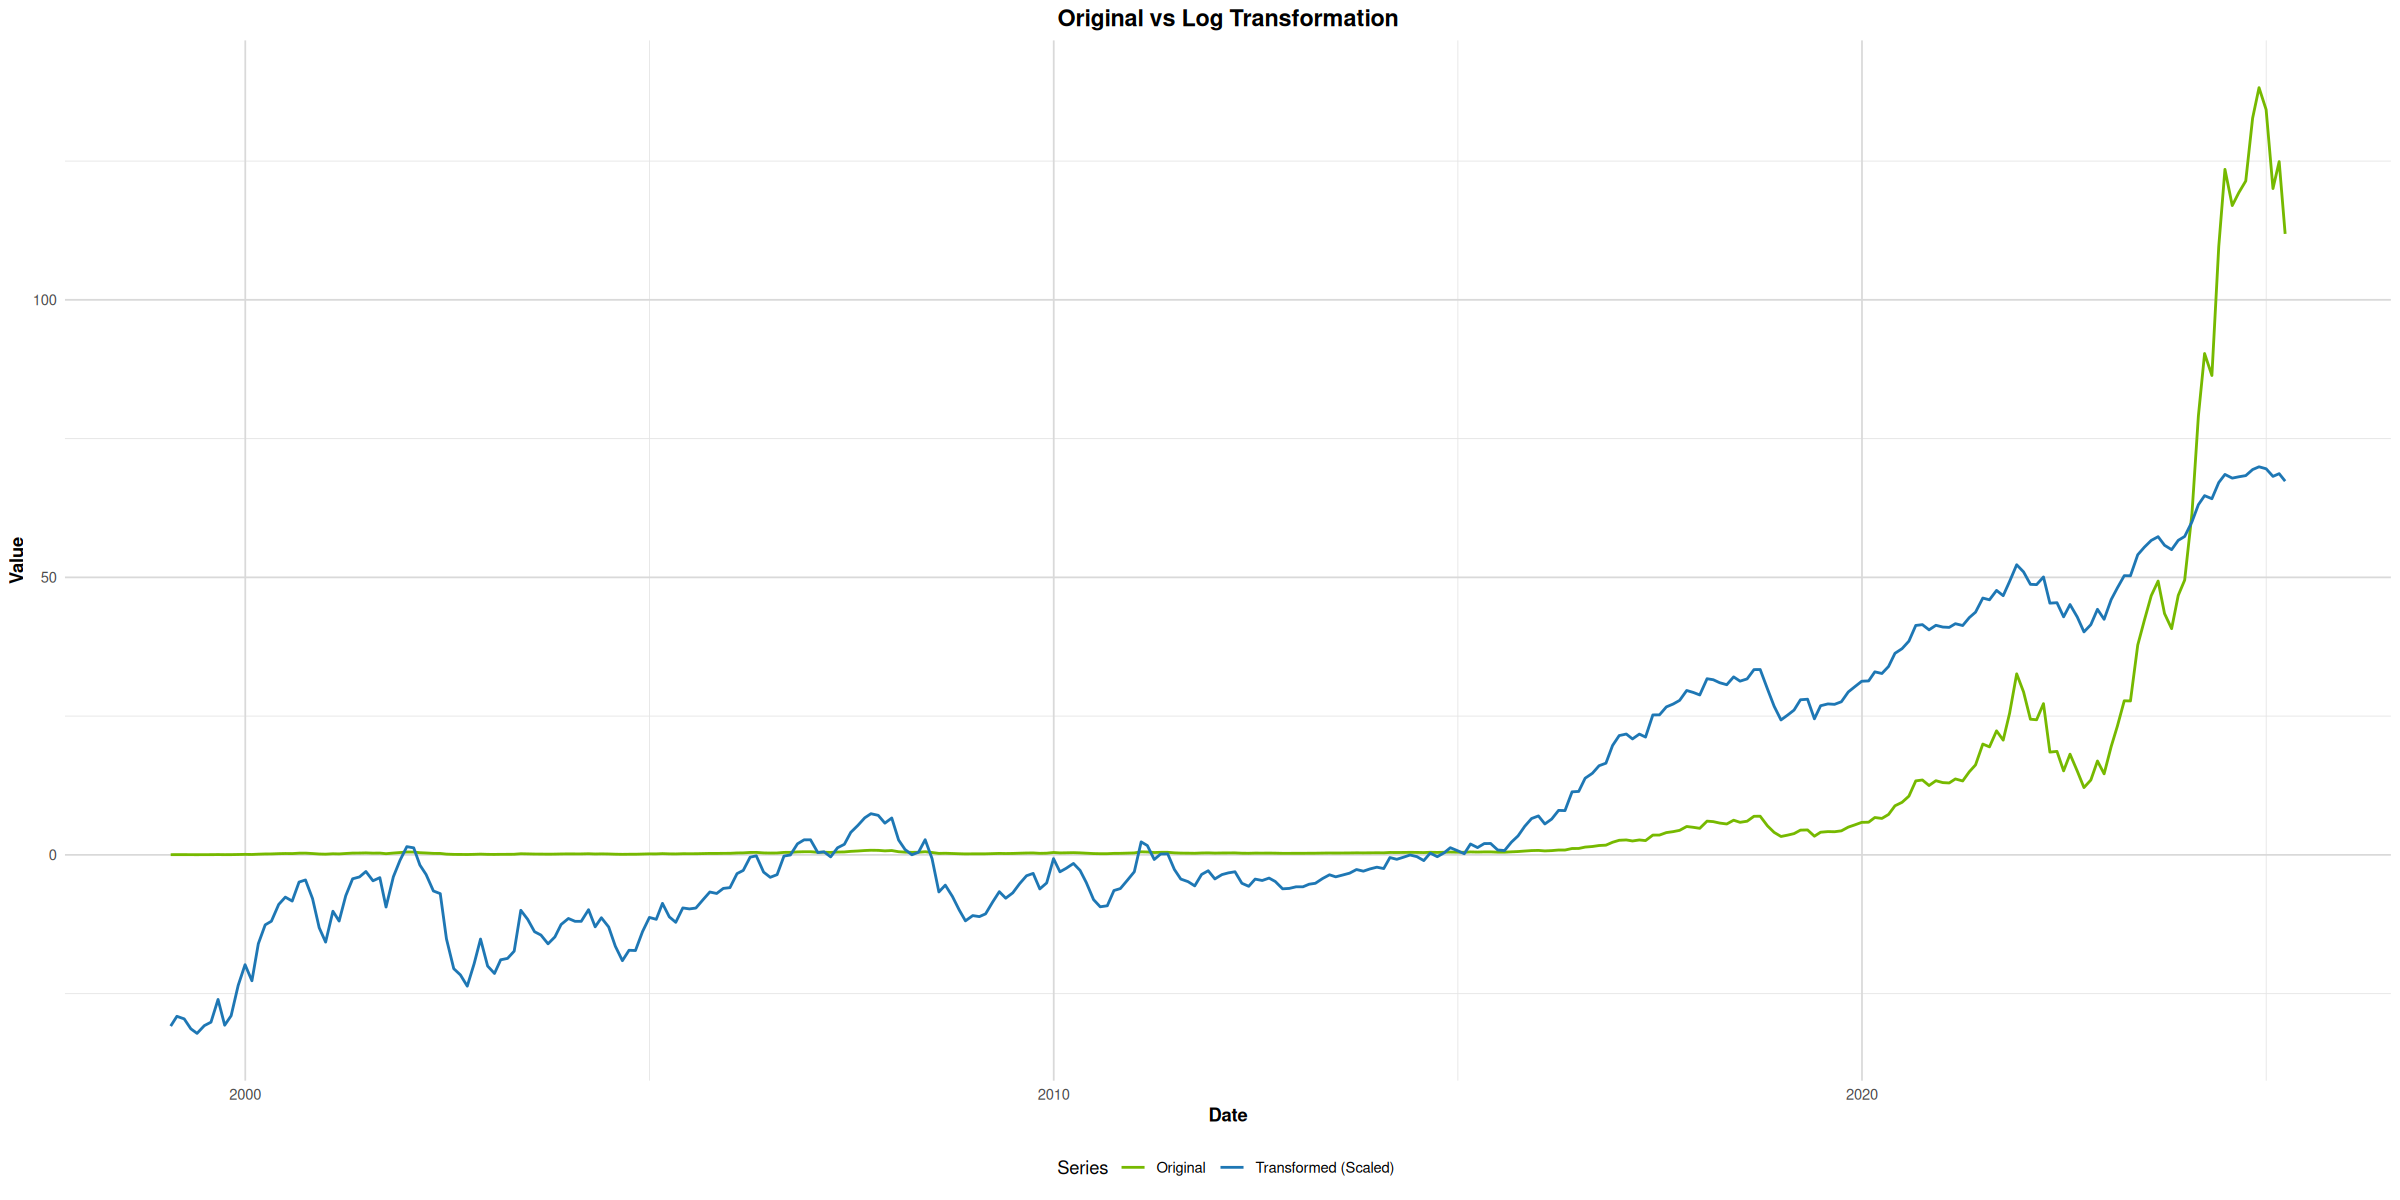

In [36]:
# box-cox transformation

lambda <- BoxCox.lambda(monthly_ts)
cat("Optimal lambda for Box-Cox transformation:", lambda, "\n")
if (abs(lambda) < 0.1) {
    cat("Lambda is close to 0, using log transformation\n")
    transformed_ts <- log(monthly_ts)
    transformation_label <- "Log Transformation"
} else {
    cat("Using Box-Cox transformation with lambda =", lambda, "\n")
    transformed_ts <- BoxCox(monthly_ts, lambda)
    transformation_label <- paste("Box-Cox Transformation (λ =", round(lambda, 4), ")")
}


transformed_df <- data.frame(
    Date = monthly_data$Date,
    Original = as.numeric(monthly_ts),
    Transformed = as.numeric(transformed_ts)
)

p_trans <- ggplot(transformed_df, aes(x = Date)) +
    geom_line(aes(y = Original, color = "Original"), size = 0.8) +
    geom_line(aes(
        y = scale(Transformed) * sd(Original) + mean(Original),
        color = "Transformed (Scaled)"
    ), size = 0.8) +
    labs(
        title = paste("Original vs", transformation_label),
        x = "Date", y = "Value",
        color = "Series"
    ) +
    scale_color_manual(values = c("Original" = "#76B900", "Transformed (Scaled)" = "#1E77B4")) +
    theme_tsa()

print(p_trans)


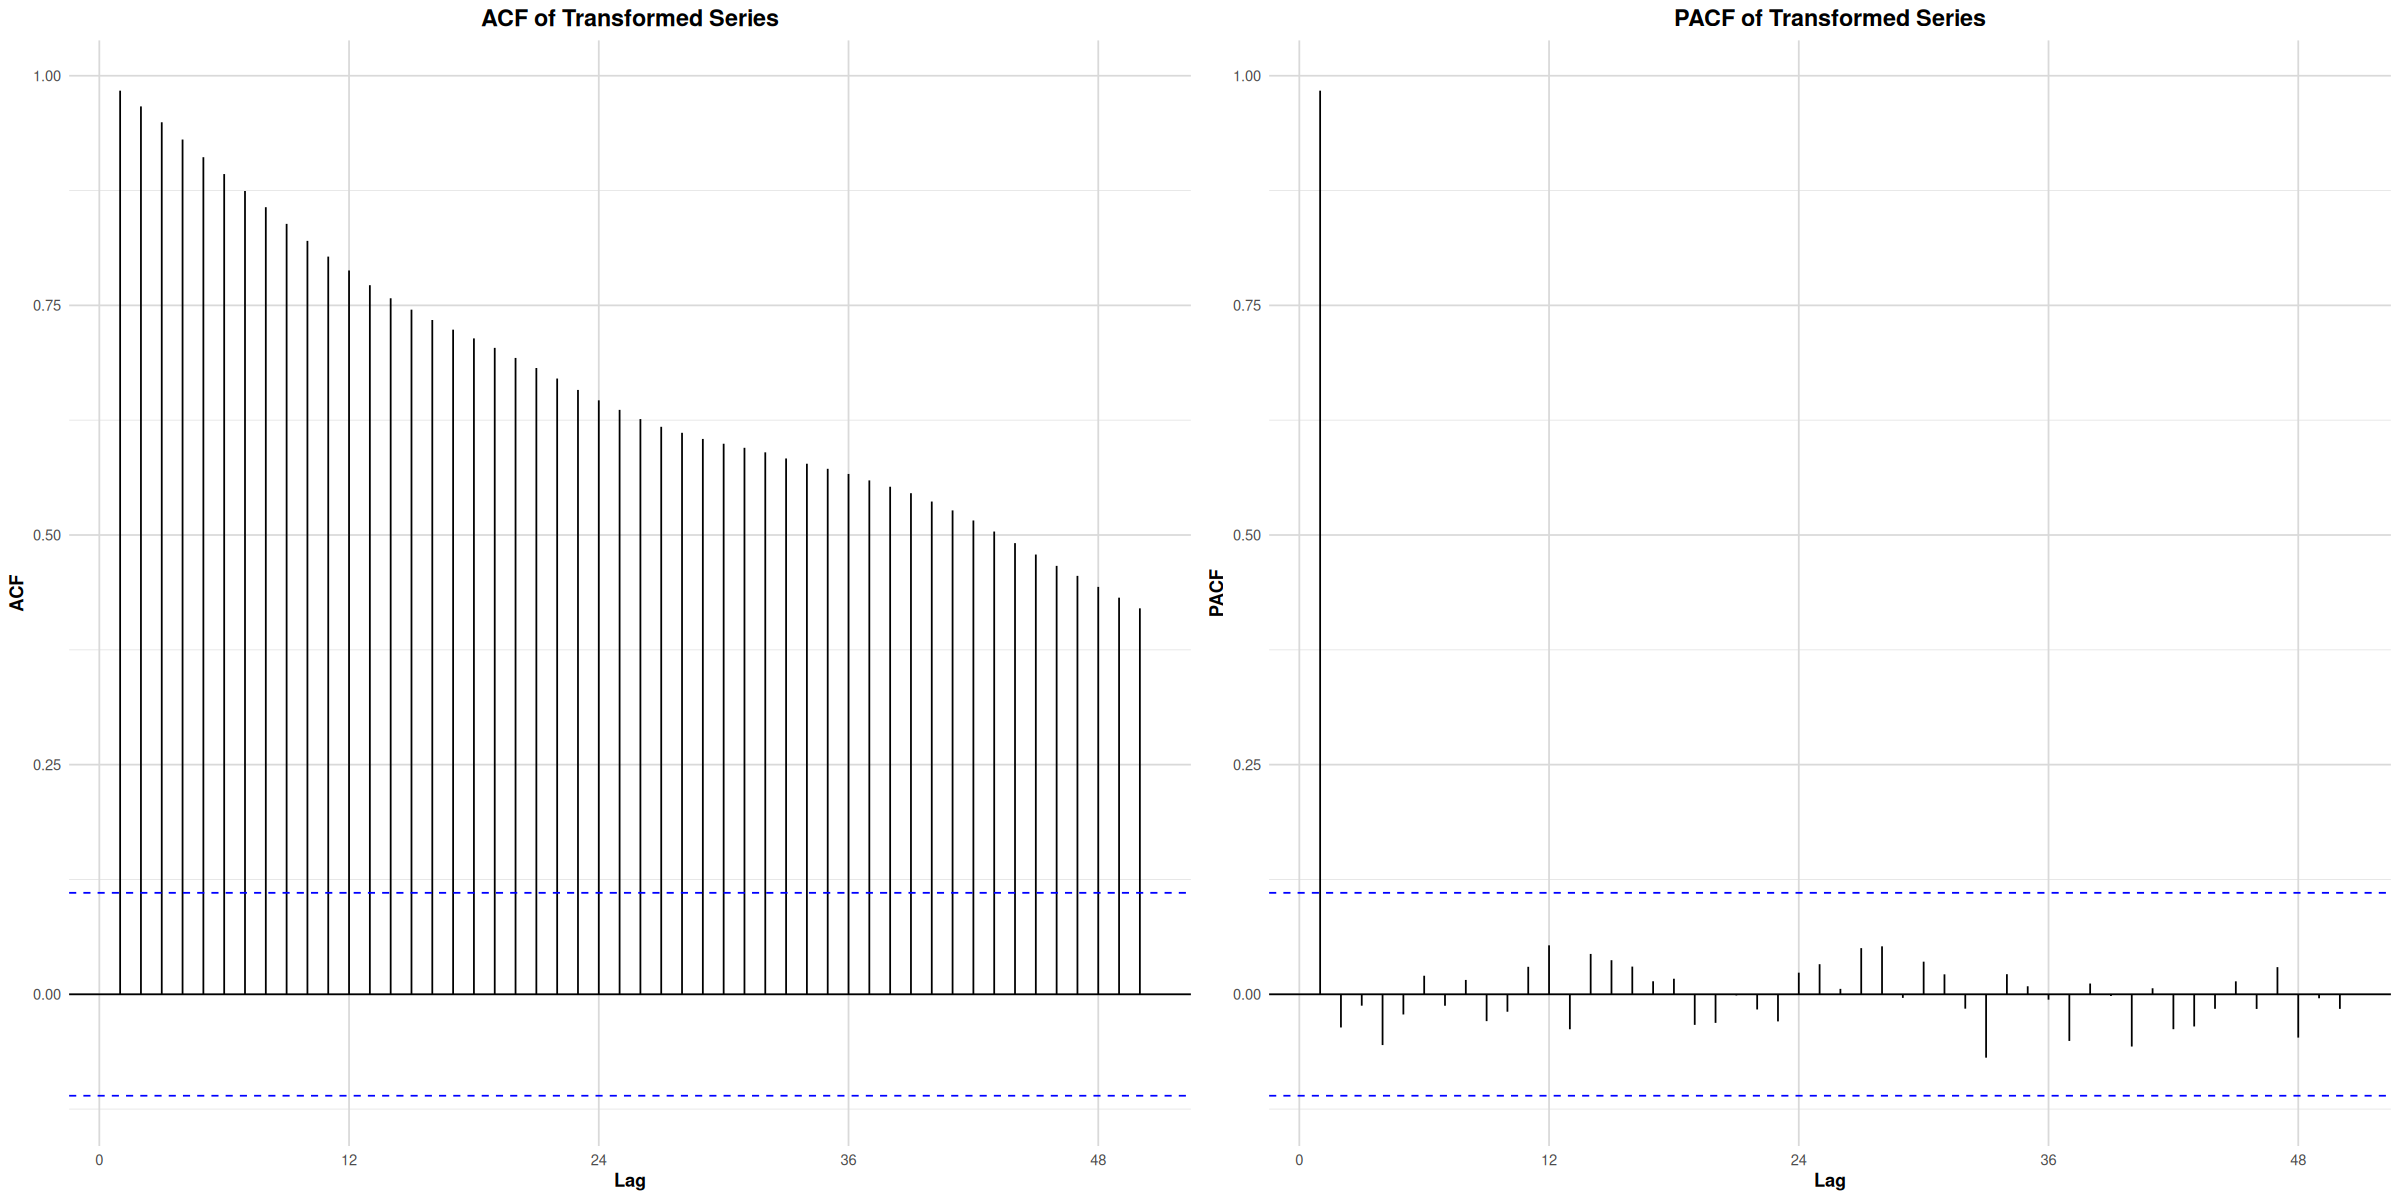

In [37]:
# ACF and PACF plots

p_acf <- ggAcf(transformed_ts, lag = 50) +
  labs(
    title = "ACF of Transformed Series",
    x = "Lag",
    y = "ACF"
  ) +
  theme_tsa()

p_pacf <- ggAcf(transformed_ts, lag = 50, type = "partial") +
    labs(
        title = "PACF of Transformed Series",
        x = "Lag",
        y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf, p_pacf, ncol = 2)

In [38]:
# test for stationarity using ADF test and KPSS test

adf_test <- adf.test(transformed_ts, alternative = "stationary")
kpss_test <- kpss.test(transformed_ts, null = "Trend")

cat("ADF Test for Stationarity:\n")
print(adf_test)

cat("\nKPSS Test for Stationarity:\n")
print(kpss_test)

cat("\nConclusion:\n")
if (adf_test$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in kpss.test(transformed_ts, null = "Trend"):
“p-value smaller than printed p-value”


ADF Test for Stationarity:

	Augmented Dickey-Fuller Test

data:  transformed_ts
Dickey-Fuller = -1.5828, Lag order = 6, p-value = 0.7523
alternative hypothesis: stationary


KPSS Test for Stationarity:

	KPSS Test for Trend Stationarity

data:  transformed_ts
KPSS Trend = 0.94871, Truncation lag parameter = 5, p-value = 0.01


Conclusion:
ADF test fails to reject the null hypothesis, series is non-stationary
KPSS test rejects the null hypothesis, series is non-stationary


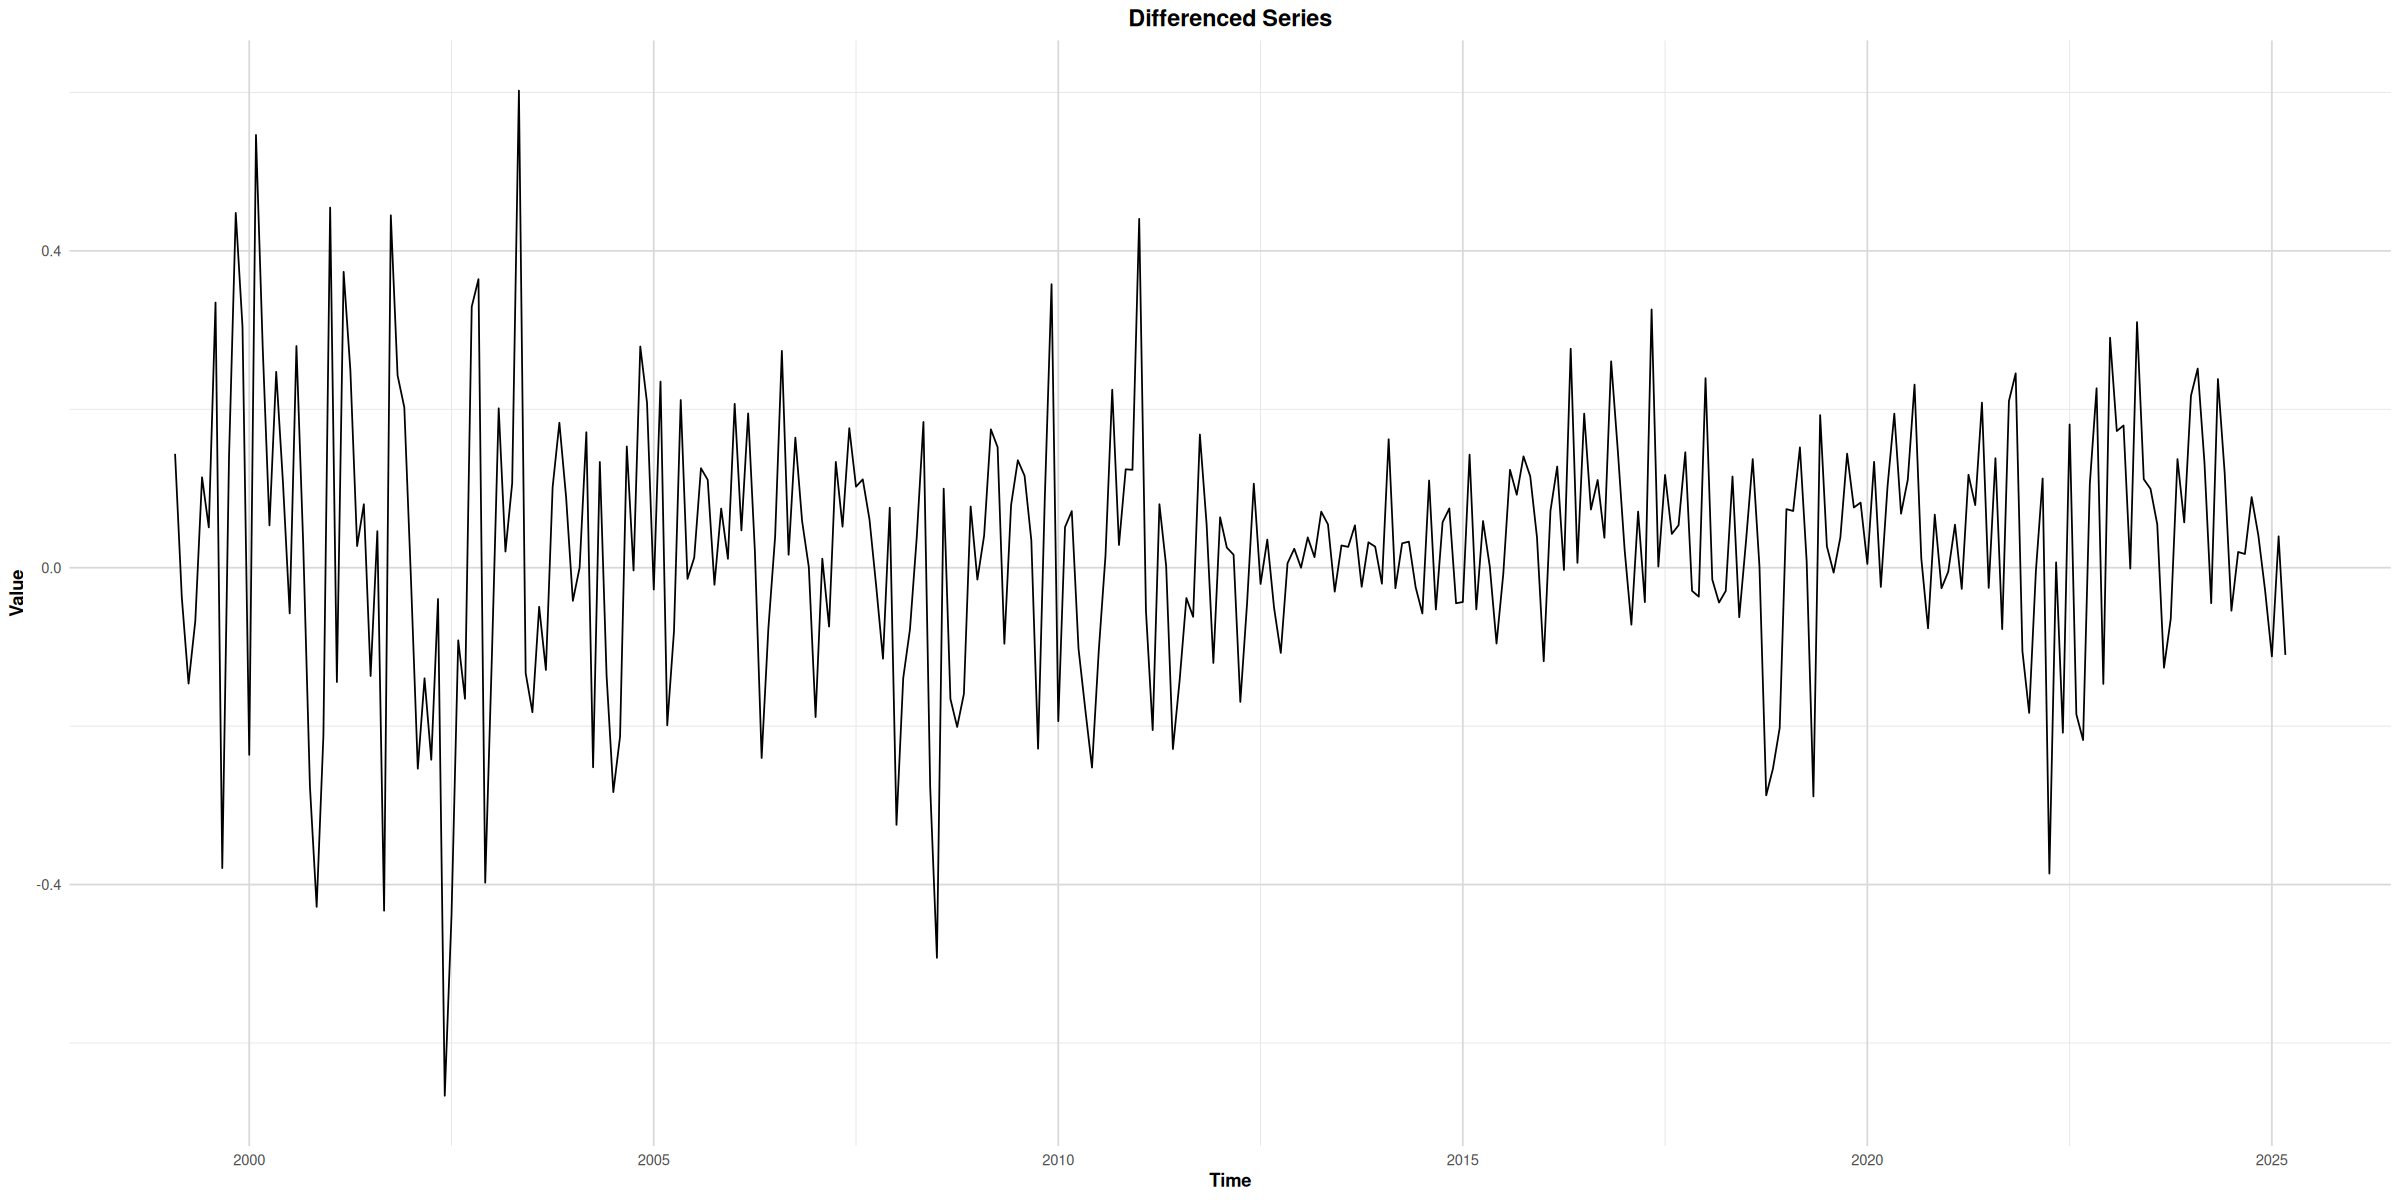

In [39]:
# differencing the series to make it stationary

diff_ts <- diff(transformed_ts)

p_diff <- autoplot(diff_ts) +
    labs(
        title = "Differenced Series",
        x = "Time", y = "Value"
    ) +
    theme_tsa()

print(p_diff)

In [40]:
# retesting for stationarity after differencing

adf_test_diff <- adf.test(diff_ts, alternative = "stationary")
kpss_test_diff <- kpss.test(diff_ts, null = "Trend")

cat("ADF Test for Stationarity (After Differencing):\n")
print(adf_test_diff)

cat("\nKPSS Test for Stationarity (After Differencing):\n")
print(kpss_test_diff)

cat("\nConclusion (After Differencing):\n")
if (adf_test_diff$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test_diff$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(diff_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(diff_ts, null = "Trend"):
“p-value greater than printed p-value”


ADF Test for Stationarity (After Differencing):

	Augmented Dickey-Fuller Test

data:  diff_ts
Dickey-Fuller = -6.4685, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity (After Differencing):

	KPSS Test for Trend Stationarity

data:  diff_ts
KPSS Trend = 0.06528, Truncation lag parameter = 5, p-value = 0.1


Conclusion (After Differencing):
ADF test rejects the null hypothesis, series is stationary
KPSS test fails to reject the null hypothesis, series is stationary


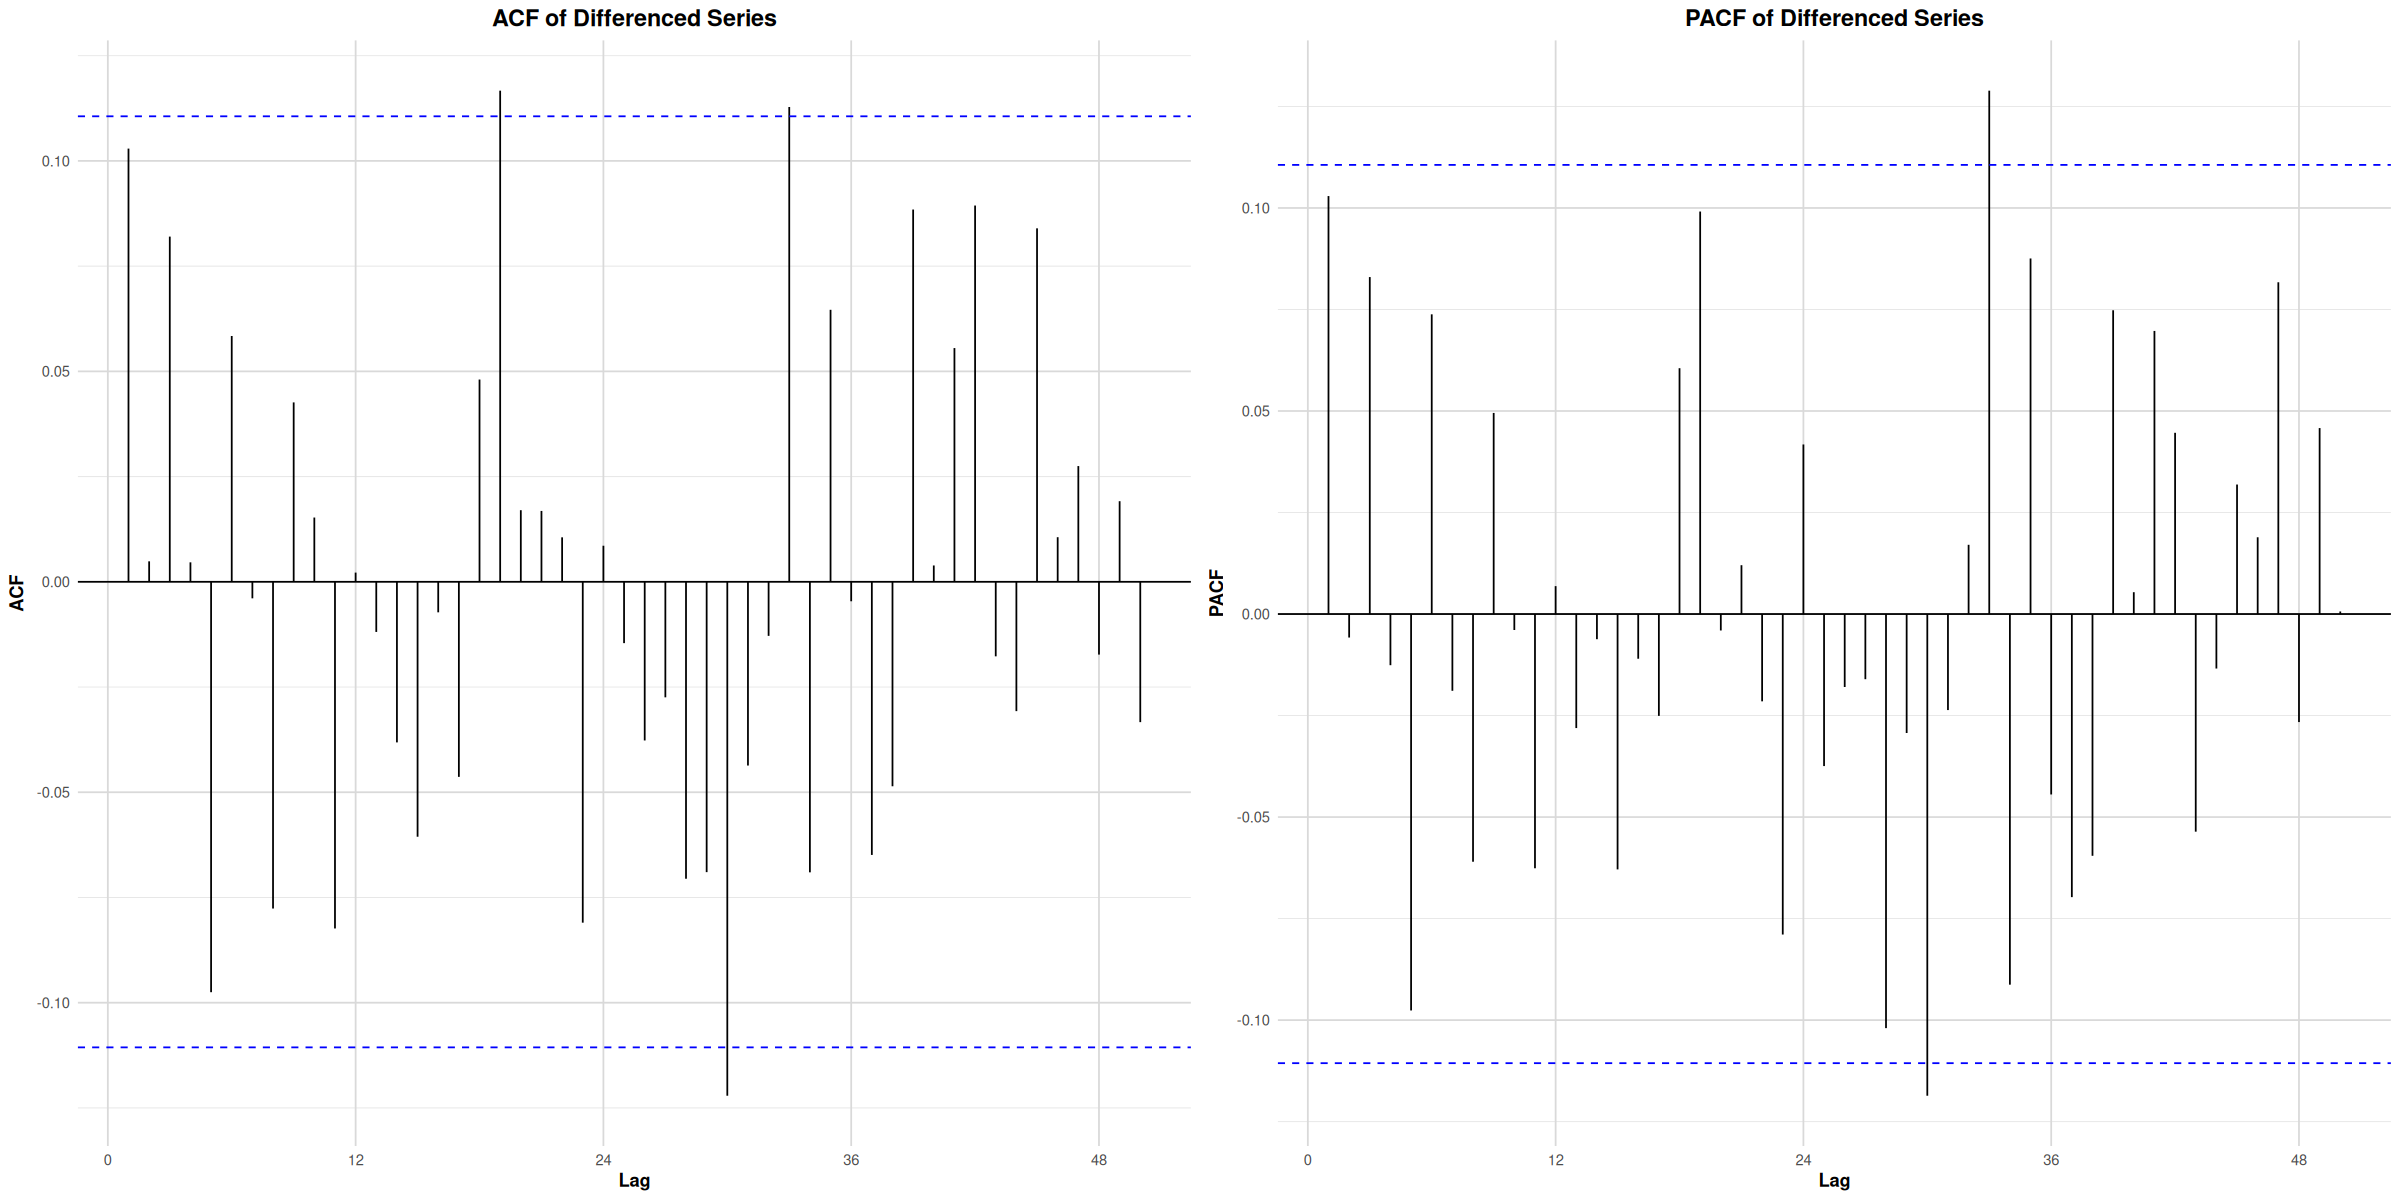

In [41]:
# ACF and PACF plots for differenced series
p_acf_diff <- ggAcf(diff_ts, lag = 50) +
    labs(
        title = "ACF of Differenced Series",
        x = "Lag", y = "ACF"
    ) +
    theme_tsa()

p_pacf_diff <- ggAcf(diff_ts, lag = 50, type = "partial") +
    labs(
        title = "PACF of Differenced Series",
        x = "Lag", y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf_diff, p_pacf_diff, ncol = 2)

**For model selection we go with two approaches, armasubsets() and grid search**

In [42]:
subset_results <- armasubsets(y = diff_ts, nar = 10, nma = 10,
                              ar.method = "ols")

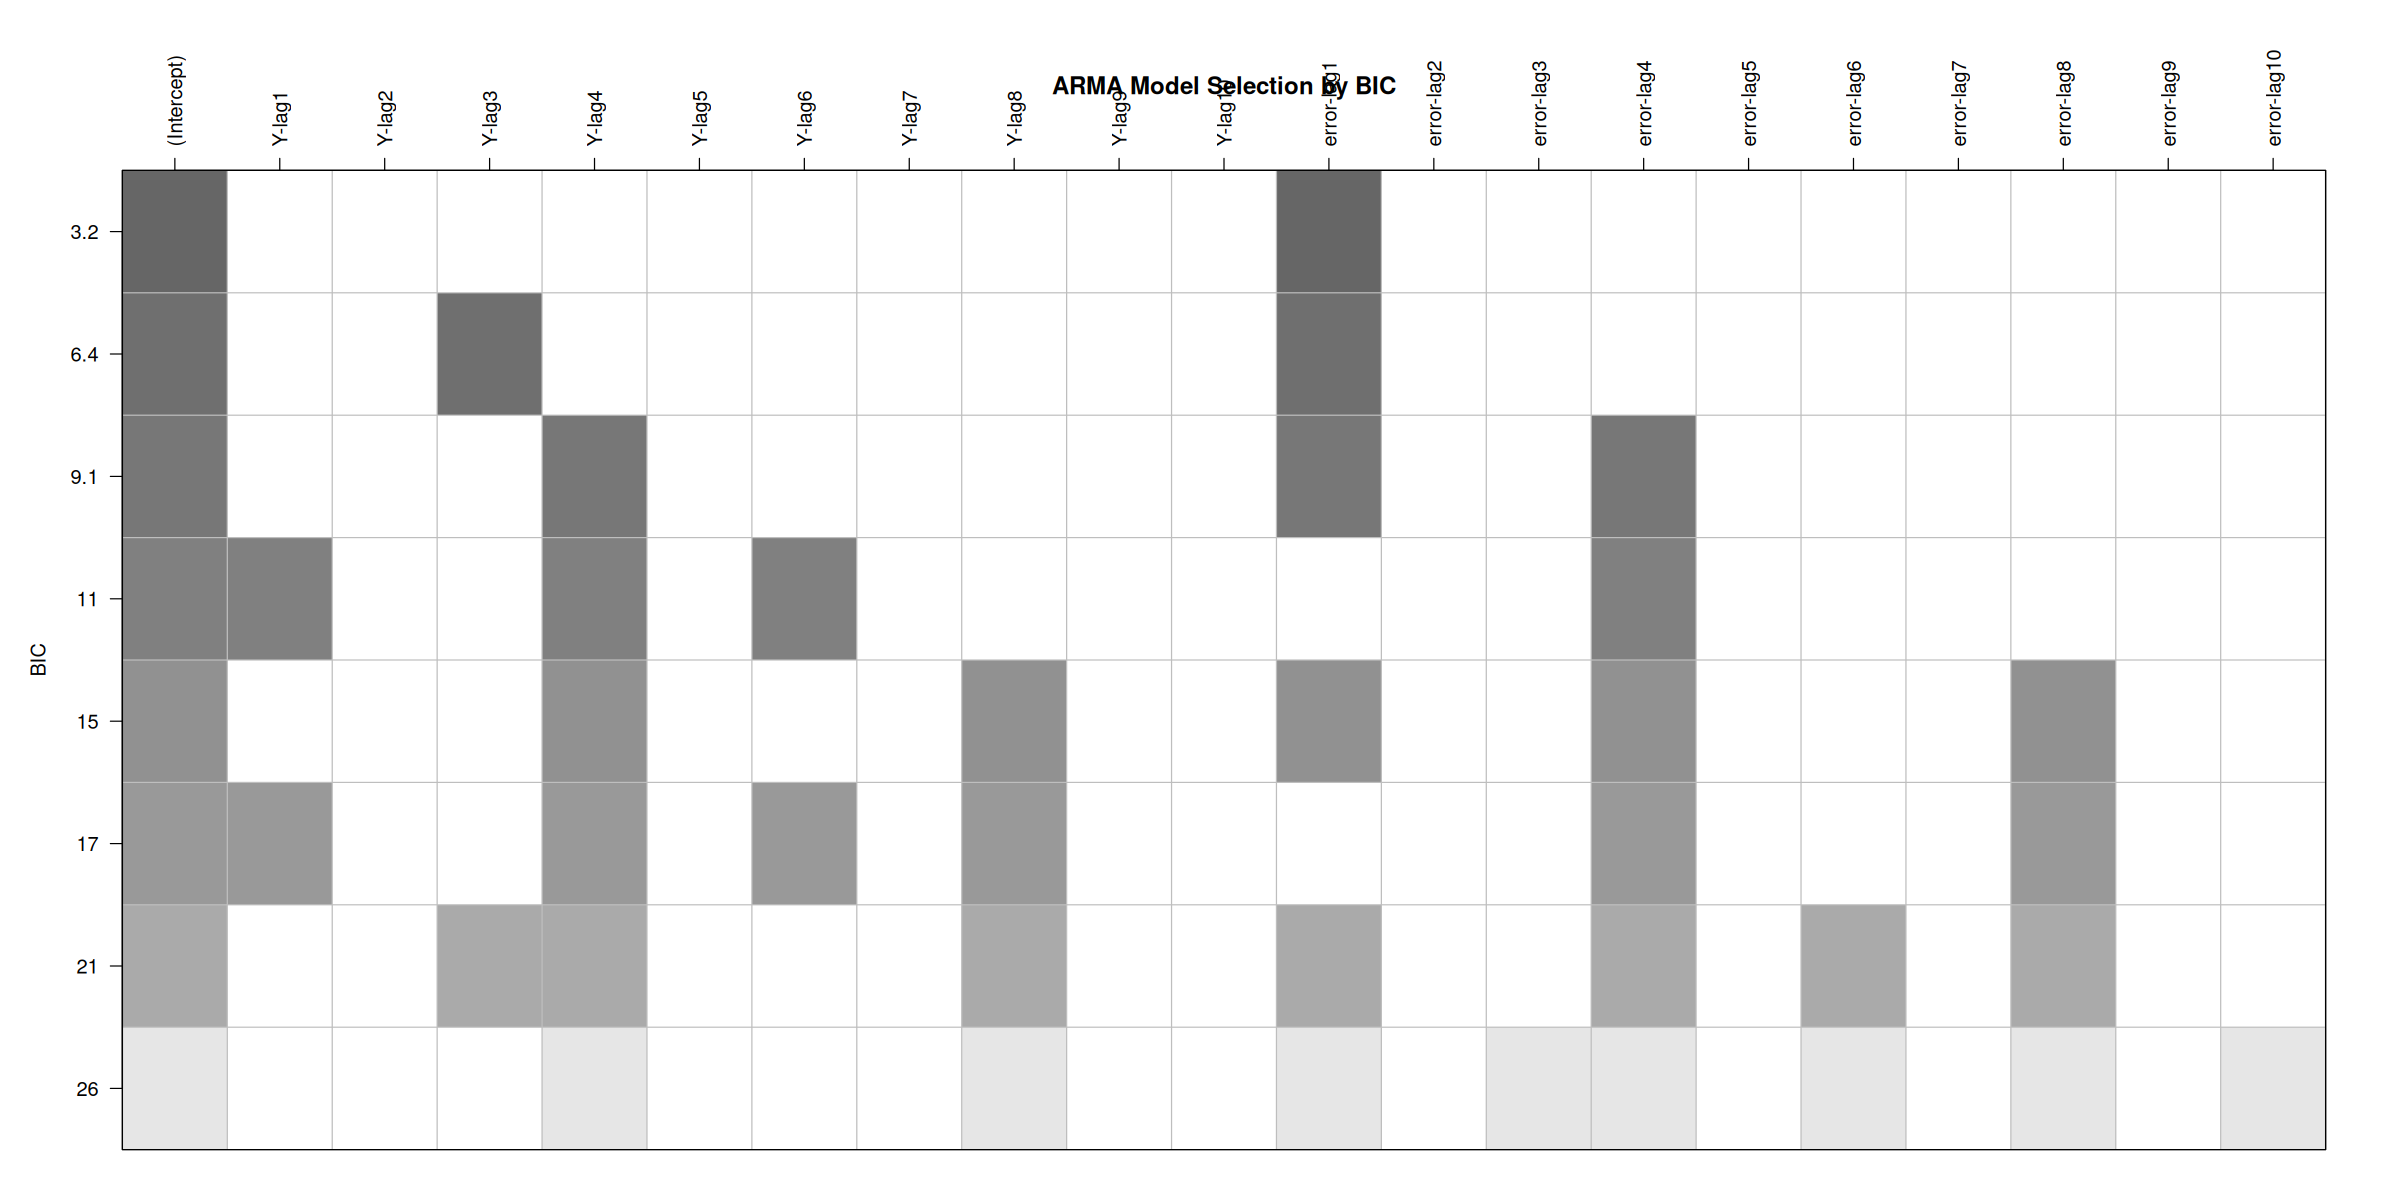

In [43]:
par(bg = "white")
plot(subset_results, which = "bic", main = "ARMA Model Selection by BIC",
     xlab = "AR and MA terms", ylab = "BIC", cex.axis = 1, cex.lab = 1)

### Best ARIMA Models Observed

From the graph, we can get the best 5 models based on the lowest BIC, they go as follow:
1. **ARIMA(0,1,1)** 
2. **ARIMA(3,1,1)**  
3. **ARIMA(4,1,4)**  
4. **ARIMA(6,1,4)**  
5. **ARIMA(8,1,8)**  

These models have demonstrated superior performance based on our evaluation metrics.

In [44]:
max_p <- 10
max_q <- 10
d <- 1

aic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)
bic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)

cat("\nFitting ARIMA models with different orders...\n")
for (p in 0:max_p) {
  for (q in 0:max_q) {
    if (p == 0 && q == 0) next
    
    cat(sprintf("Fitting ARIMA(%d,%d,%d)...\n", p, d, q))
    
    tryCatch({
      model <- Arima(transformed_ts, order = c(p, d, q))
      aic_values[p+1, q+1] <- model$aic
      bic_values[p+1, q+1] <- model$bic
    }, error = function(e) {
      cat("  Error:", e$message, "\n")
    })
  }
}

model_data <- data.frame(
  p = rep(0:max_p, each = max_q + 1),
  q = rep(0:max_q, max_p + 1),
  AIC = as.vector(aic_values),
  BIC = as.vector(bic_values)
)

model_data <- model_data[!is.na(model_data$AIC) & !is.na(model_data$BIC), ]

model_data$Model <- paste0("(", model_data$p, ",1,", model_data$q, ")")

best_aic_model <- model_data[which.min(model_data$AIC), ]
best_bic_model <- model_data[which.min(model_data$BIC), ]

cat("\nBest model by AIC: ARIMA", best_aic_model$Model, "with AIC =", round(best_aic_model$AIC, 2), "\n")
cat("Best model by BIC: ARIMA", best_bic_model$Model, "with BIC =", round(best_bic_model$BIC, 2), "\n")



Fitting ARIMA models with different orders...


Fitting ARIMA(0,1,1)...
Fitting ARIMA(0,1,2)...
Fitting ARIMA(0,1,3)...
Fitting ARIMA(0,1,4)...
Fitting ARIMA(0,1,5)...
Fitting ARIMA(0,1,6)...
Fitting ARIMA(0,1,7)...
Fitting ARIMA(0,1,8)...
Fitting ARIMA(0,1,9)...
Fitting ARIMA(0,1,10)...
Fitting ARIMA(1,1,0)...
Fitting ARIMA(1,1,1)...
Fitting ARIMA(1,1,2)...
Fitting ARIMA(1,1,3)...
Fitting ARIMA(1,1,4)...
Fitting ARIMA(1,1,5)...
Fitting ARIMA(1,1,6)...
Fitting ARIMA(1,1,7)...
Fitting ARIMA(1,1,8)...
Fitting ARIMA(1,1,9)...
Fitting ARIMA(1,1,10)...
Fitting ARIMA(2,1,0)...
Fitting ARIMA(2,1,1)...
Fitting ARIMA(2,1,2)...
Fitting ARIMA(2,1,3)...
Fitting ARIMA(2,1,4)...
Fitting ARIMA(2,1,5)...
Fitting ARIMA(2,1,6)...
Fitting ARIMA(2,1,7)...
Fitting ARIMA(2,1,8)...
Fitting ARIMA(2,1,9)...
Fitting ARIMA(2,1,10)...
Fitting ARIMA(3,1,0)...
Fitting ARIMA(3,1,1)...
Fitting ARIMA(3,1,2)...
Fitting ARIMA(3,1,3)...
Fitting ARIMA(3,1,4)...
Fitting ARIMA(3,1,5)...
Fitting ARIMA(3,1,6)...
Fitting ARIMA(3,1,7)...
Fitting ARIMA(3,1,8)...
Fitting ARIMA

**Grid search returned these as the best models :**
- Best model by AIC: ARIMA (9,1,10) with AIC = 1412.51 
- Best model by BIC: ARIMA (9,1,5) with BIC = 1477.22 

### Resolving Model Selection Conflict  

 **The two methods suggest different "best" models:**  
- **ARMASUBSETS** favors simpler models.  
- **Grid search** identifies more complex models with lower AIC/BIC.  

#### Resolution Strategy  
To determine the truly best model, we will **compare forecast accuracy** using **out-of-sample testing**. 


In [45]:
# Split data for training and testing
n_months <- length(monthly_ts)
train_end <- n_months - 12

train_ts <- window(monthly_ts, end = c(time(monthly_ts)[train_end]))
test_ts <- window(monthly_ts, start = c(time(monthly_ts)[train_end + 1]))


In [46]:
# Define the specific models to test
model_specs <- list(
  list(p=0, d=1, q=1, name="ARIMA(0,1,1) - Simple MA"),
  list(p=3, d=1, q=1, name="ARIMA(3,1,1)"),
  list(p=4, d=1, q=4, name="ARIMA(4,1,4)"),
  list(p=6, d=1, q=4, name="ARIMA(6,1,4)"),
  list(p=8, d=1, q=8, name="ARIMA(8,1,8)"),
  list(p=9, d=1, q=5, name="ARIMA(9,1,5) - Best BIC"),
  list(p=9, d=1, q=10, name="ARIMA(9,1,10) - Best AIC")
)

# Initialize model results dataframe
model_results <- data.frame(
  Model = character(),
  AIC = numeric(),
  BIC = numeric(),
  LogLik = numeric(),
  RMSE_train = numeric(),
  stringsAsFactors = FALSE
)

# Fit each model
fitted_models <- list()

for (spec in model_specs) {
  model_name <- spec$name
  p <- spec$p
  d <- spec$d
  q <- spec$q
  
  cat(sprintf("\nFitting %s...\n", model_name))
  
  tryCatch({
    # Fit model
    model <- Arima(train_ts, order = c(p, d, q))
    
    # Get in-sample metrics
    aic <- model$aic
    bic <- model$bic
    loglik <- model$loglik
    rmse_train <- sqrt(mean(model$residuals^2))
    
    # Store model
    fitted_models[[model_name]] <- model
    
    # Add to results
    model_results <- rbind(model_results, data.frame(
      Model = model_name,
      AIC = aic,
      BIC = bic,
      LogLik = loglik,
      RMSE_train = rmse_train
    ))
    
    cat(sprintf("AIC: %.2f, BIC: %.2f\n", aic, bic))
    
  }, error = function(e) {
    cat("  Error:", e$message, "\n")
  })
}

# Sort by AIC
model_results <- model_results[order(model_results$AIC), ]

cat("\nModel comparison by information criteria:\n")
print(model_results[, c("Model", "AIC", "BIC", "RMSE_train")])


Fitting ARIMA(0,1,1) - Simple MA...
AIC: 1220.87, BIC: 1228.30

Fitting ARIMA(3,1,1)...
AIC: 1193.33, BIC: 1211.89

Fitting ARIMA(4,1,4)...
AIC: 1128.03, BIC: 1161.42

Fitting ARIMA(6,1,4)...
AIC: 1128.85, BIC: 1169.67

Fitting ARIMA(8,1,8)...
  Error: non-stationary AR part from CSS 

Fitting ARIMA(9,1,5) - Best BIC...
  Error: non-stationary AR part from CSS 

Fitting ARIMA(9,1,10) - Best AIC...
  Error: non-stationary AR part from CSS 

Model comparison by information criteria:
                     Model      AIC      BIC RMSE_train
3             ARIMA(4,1,4) 1128.028 1161.422   1.483842
4             ARIMA(6,1,4) 1128.853 1169.667   1.489470
2             ARIMA(3,1,1) 1193.333 1211.885   1.711805
1 ARIMA(0,1,1) - Simple MA 1220.875 1228.296   1.810993


In [47]:
# Generate forecasts for each model and evaluate against test data
forecast_results <- data.frame(
  Model = character(),
  RMSE = numeric(),
  MAE = numeric(),
  MAPE = numeric(),
  stringsAsFactors = FALSE
)

for (model_name in names(fitted_models)) {
  model <- fitted_models[[model_name]]
  forecast_result <- forecast(model, h = length(test_ts))

  # Calculate accuracy metrics
  accuracy_metrics <- accuracy(forecast_result, test_ts)
  test_metrics <- accuracy_metrics["Test set", ]

  # Add to results
  forecast_results <- rbind(forecast_results, data.frame(
    Model = model_name,
    RMSE = test_metrics["RMSE"],
    MAE = test_metrics["MAE"],
    MAPE = test_metrics["MAPE"]
  ))
}

# Sort by RMSE
forecast_results <- forecast_results[order(forecast_results$RMSE), ]

cat("\nOut-of-sample forecast accuracy comparison:\n")
print(forecast_results)

# Identify the best model by out-of-sample RMSE
best_model_name <- forecast_results$Model[1]
cat("\nBest model based on forecast accuracy (RMSE):", best_model_name, "\n")

# Get the best model
best_model <- fitted_models[[best_model_name]]
best_order <- c(
  as.numeric(gsub(".*\\((\\d+),1,\\d+\\).*", "\\1", best_model_name)),
  1,
  as.numeric(gsub(".*\\(\\d+,1,(\\d+)\\).*", "\\1", best_model_name))
)



Out-of-sample forecast accuracy comparison:
                         Model     RMSE       MAE      MAPE
RMSE1             ARIMA(3,1,1) 13.33062  9.859239  8.630815
RMSE3             ARIMA(6,1,4) 24.52953 22.922989 18.555840
RMSE  ARIMA(0,1,1) - Simple MA 30.27322 28.348974 22.890535
RMSE2             ARIMA(4,1,4) 39.20424 37.212046 30.231758

Best model based on forecast accuracy (RMSE): ARIMA(3,1,1) 


## Model Fitting Results

When attempting to fit various ARIMA models to the NVIDIA stock price data, we observed several interesting outcomes:

- The simpler models (ARIMA(0,1,1), ARIMA(3,1,1), ARIMA(4,1,4), and ARIMA(6,1,4)) successfully converged, indicating they could adequately represent the underlying data patterns.

- However, the more complex models (ARIMA(8,1,8), ARIMA(9,1,5), and ARIMA(9,1,10)) failed to converge with the error "non-stationary AR part from CSS." This suggests these models are overparameterized for our data, potentially trying to fit noise rather than signal.

- This aligns with financial theory, which suggests that while stock prices can exhibit complex behaviors, they often follow relatively simple time series patterns after differencing.

The failure of the more complex models demonstrates an important principle in time series modeling: more parameters do not always lead to better models, especially when the underlying process has a relatively simple structure.

## Information Criteria Comparison

The information criteria comparison provides insights into the in-sample fit of our models:

| Model | AIC | BIC | RMSE_train |
|-------|-----|-----|------------|
| ARIMA(4,1,4) | 1128.028 | 1161.422 | 1.483842 |
| ARIMA(6,1,4) | 1128.853 | 1169.667 | 1.489470 |
| ARIMA(3,1,1) | 1193.333 | 1211.885 | 1.711805 |
| ARIMA(0,1,1) - Simple MA | 1220.875 | 1228.296 | 1.810993 |

- **In-sample fit**: The ARIMA(4,1,4) model has the lowest AIC (1128.03) and in-sample RMSE (1.48), indicating it provides the best fit to the training data.

- **Parsimony penalty**: While the ARIMA(4,1,4) has the lowest AIC, its BIC (1161.42) is higher than we might desire, reflecting the BIC's stronger penalty for model complexity.

- **Model complexity trade-off**: The ARIMA(6,1,4) model has a slightly worse AIC (1128.85) but a considerably higher BIC (1169.67), suggesting the additional parameters may not justify the marginal improvement in fit.

- **Simple model performance**: The simplest model, ARIMA(0,1,1), has the highest information criteria values, indicating worse in-sample fit but with minimal parameters (essentially an exponential smoothing model).

This analysis highlights the classic bias-variance tradeoff in statistical modeling - more complex models fit the training data better but risk overfitting.

## Out-of-Sample Forecast Accuracy

The true test of a time series model is its forecasting performance on unseen data:

| Model | RMSE | MAE | MAPE |
|-------|------|-----|------|
| ARIMA(3,1,1) | 13.33062 | 9.859239 | 8.630815 |
| ARIMA(6,1,4) | 24.52953 | 22.922989 | 18.555840 |
| ARIMA(0,1,1) - Simple MA | 30.27322 | 28.348974 | 22.890535 |
| ARIMA(4,1,4) | 39.20424 | 37.212046 | 30.231758 |

- **Best forecaster**: The ARIMA(3,1,1) model significantly outperforms all other models with the lowest RMSE (13.33), MAE (9.86), and MAPE (8.63%), demonstrating superior predictive accuracy.

- **Model complexity paradox**: Interestingly, the ARIMA(4,1,4) model, which had the best in-sample fit, performs worst in out-of-sample forecasting (RMSE: 39.20). This is a classic example of overfitting - the model learned the noise in the training data rather than the underlying signal.

- **Complexity balance**: The ARIMA(6,1,4) performs better than both the simplest model and the ARIMA(4,1,4), suggesting it strikes a better balance between flexibility and generalizability for this particular dataset.

- **Simple model resilience**: While the ARIMA(0,1,1) doesn't match the forecasting ability of ARIMA(3,1,1), it outperforms the more complex ARIMA(4,1,4) model, demonstrating that simpler models can sometimes be more robust to changes in the underlying data.

This analysis highlights a fundamental principle in time series forecasting: the model with the best in-sample fit rarely produces the best forecasts. The ARIMA(3,1,1) model achieves the best balance between capturing meaningful patterns and avoiding overfitting.

## Final Model Selection

Based on comprehensive evaluation of both in-sample fit and out-of-sample forecasting performance, **ARIMA(3,1,1)** emerges as the optimal model for forecasting NVIDIA stock prices.

This model specification indicates:
- **Differencing (d=1)**: The original price series requires first-order differencing to achieve stationarity, which aligns with the random walk nature of stock prices.
- **Autoregressive component (p=3)**: The model incorporates information from the previous three lagged values of the differenced series, capturing the medium-term momentum patterns often observed in stock prices.
- **Moving average component (q=1)**: The inclusion of a first-order moving average term allows the model to account for short-term random shocks.

The ARIMA(3,1,1) specification strikes an optimal balance between:
1. Model complexity (fewer parameters than alternatives like ARIMA(4,1,4))
2. Forecasting accuracy (63% lower RMSE than the more complex ARIMA(4,1,4) model)
3. Practical interpretability (aligns with known financial market behaviors)

This model selection demonstrates the importance of out-of-sample validation in time series forecasting and reinforces that the most theoretically complex models aren't necessarily the most useful for practical purposes.

## ARIMA Model Selection in the Context of NVIDIA's AI Boom

The selection of ARIMA(3,1,1) as the optimal forecasting model provides interesting insights into NVIDIA's stock price dynamics during the AI boom:

1. **Moderate memory length**: The 3-period autoregressive component suggests NVIDIA's stock price movements have a "memory" that extends back approximately one quarter. This moderate memory length indicates that while the market doesn't perfectly follow random walk behavior (which would favor an ARIMA(0,1,1) model), it also doesn't show extremely long-term dependencies.

2. **AI announcement effects**: The presence of a moving average component captures the short-term impact of unexpected events, such as major AI product announcements. This aligns with our event impact analysis showing significant price movements following key AI announcements.

3. **Balance of trend and volatility**: The model's structure successfully balances NVIDIA's strong upward trend during the AI boom period with the inherent volatility of tech stocks. The relatively low MAPE of 8.63% demonstrates the model can capture these dynamics despite the unprecedented growth.

4. **Model parsimony reflects market efficiency**: While NVIDIA has experienced extraordinary growth due to AI adoption, the fact that a relatively parsimonious model provides the best forecasts supports the semi-strong form of market efficiency. This suggests that while the market reacts strongly to new AI developments, it does so in a manner that doesn't leave overly exploitable patterns.

The effectiveness of ARIMA(3,1,1) in this context underscores how traditional time series methods remain valuable even when modeling stocks influenced by transformative technological shifts like the AI revolution.

In [48]:
best_order <- c(3, 1, 1)
final_model <- Arima(monthly_ts, order = best_order)

cat("\nFINAL MODEL: ARIMA(3,1,1)\n")
cat("-------------------------------\n")
cat("Model Summary:\n")
print(summary(final_model))



FINAL MODEL: ARIMA(3,1,1)
-------------------------------
Model Summary:
Series: monthly_ts 
ARIMA(3,1,1) 

Coefficients:
         ar1      ar2     ar3      ma1
      0.5391  -0.0618  0.2525  -0.3456
s.e.  0.1311   0.0696  0.0654   0.1313

sigma^2 = 7.094:  log likelihood = -751.33
AIC=1512.66   AICc=1512.86   BIC=1531.41

Training set error measures:
                    ME    RMSE       MAE      MPE     MAPE      MASE
Training set 0.1105815 2.64229 0.9238755 0.829325 12.97742 0.1703624
                    ACF1
Training set -0.01250096



======= DIAGNOSTICS FOR ARIMA(3,1,1) =======

1. Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  res
W = 0.51642, p-value < 2.2e-16

Conclusion: Residuals are NOT normally distributed 

2. Ljung-Box test for autocorrelation:

	Box-Ljung test

data:  res
X-squared = 24.659, df = 12, p-value = 0.01652

Conclusion: Residuals are NOT independent (autocorrelation present) 

3. ARCH test for homoskedasticity:

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  res
Chi-squared = 219.57, df = 12, p-value < 2.2e-16

Conclusion: Residuals have NON-constant variance (ARCH effects) 

4. Runs test for randomness:

	Runs Test - Two sided

data:  res > 0
Standardized Runs Statistic = -Inf, p-value < 2.2e-16

Conclusion: Residuals are NOT random 

5. Summary of Diagnostic Tests:
-----------------------------------
Normality:        FAIL 
Independence:     FAIL 
Homoskedasticity: FAIL 
Randomness:       FAIL 
-----------------------------------

======= DIAGNOSTICS FOR ARIM

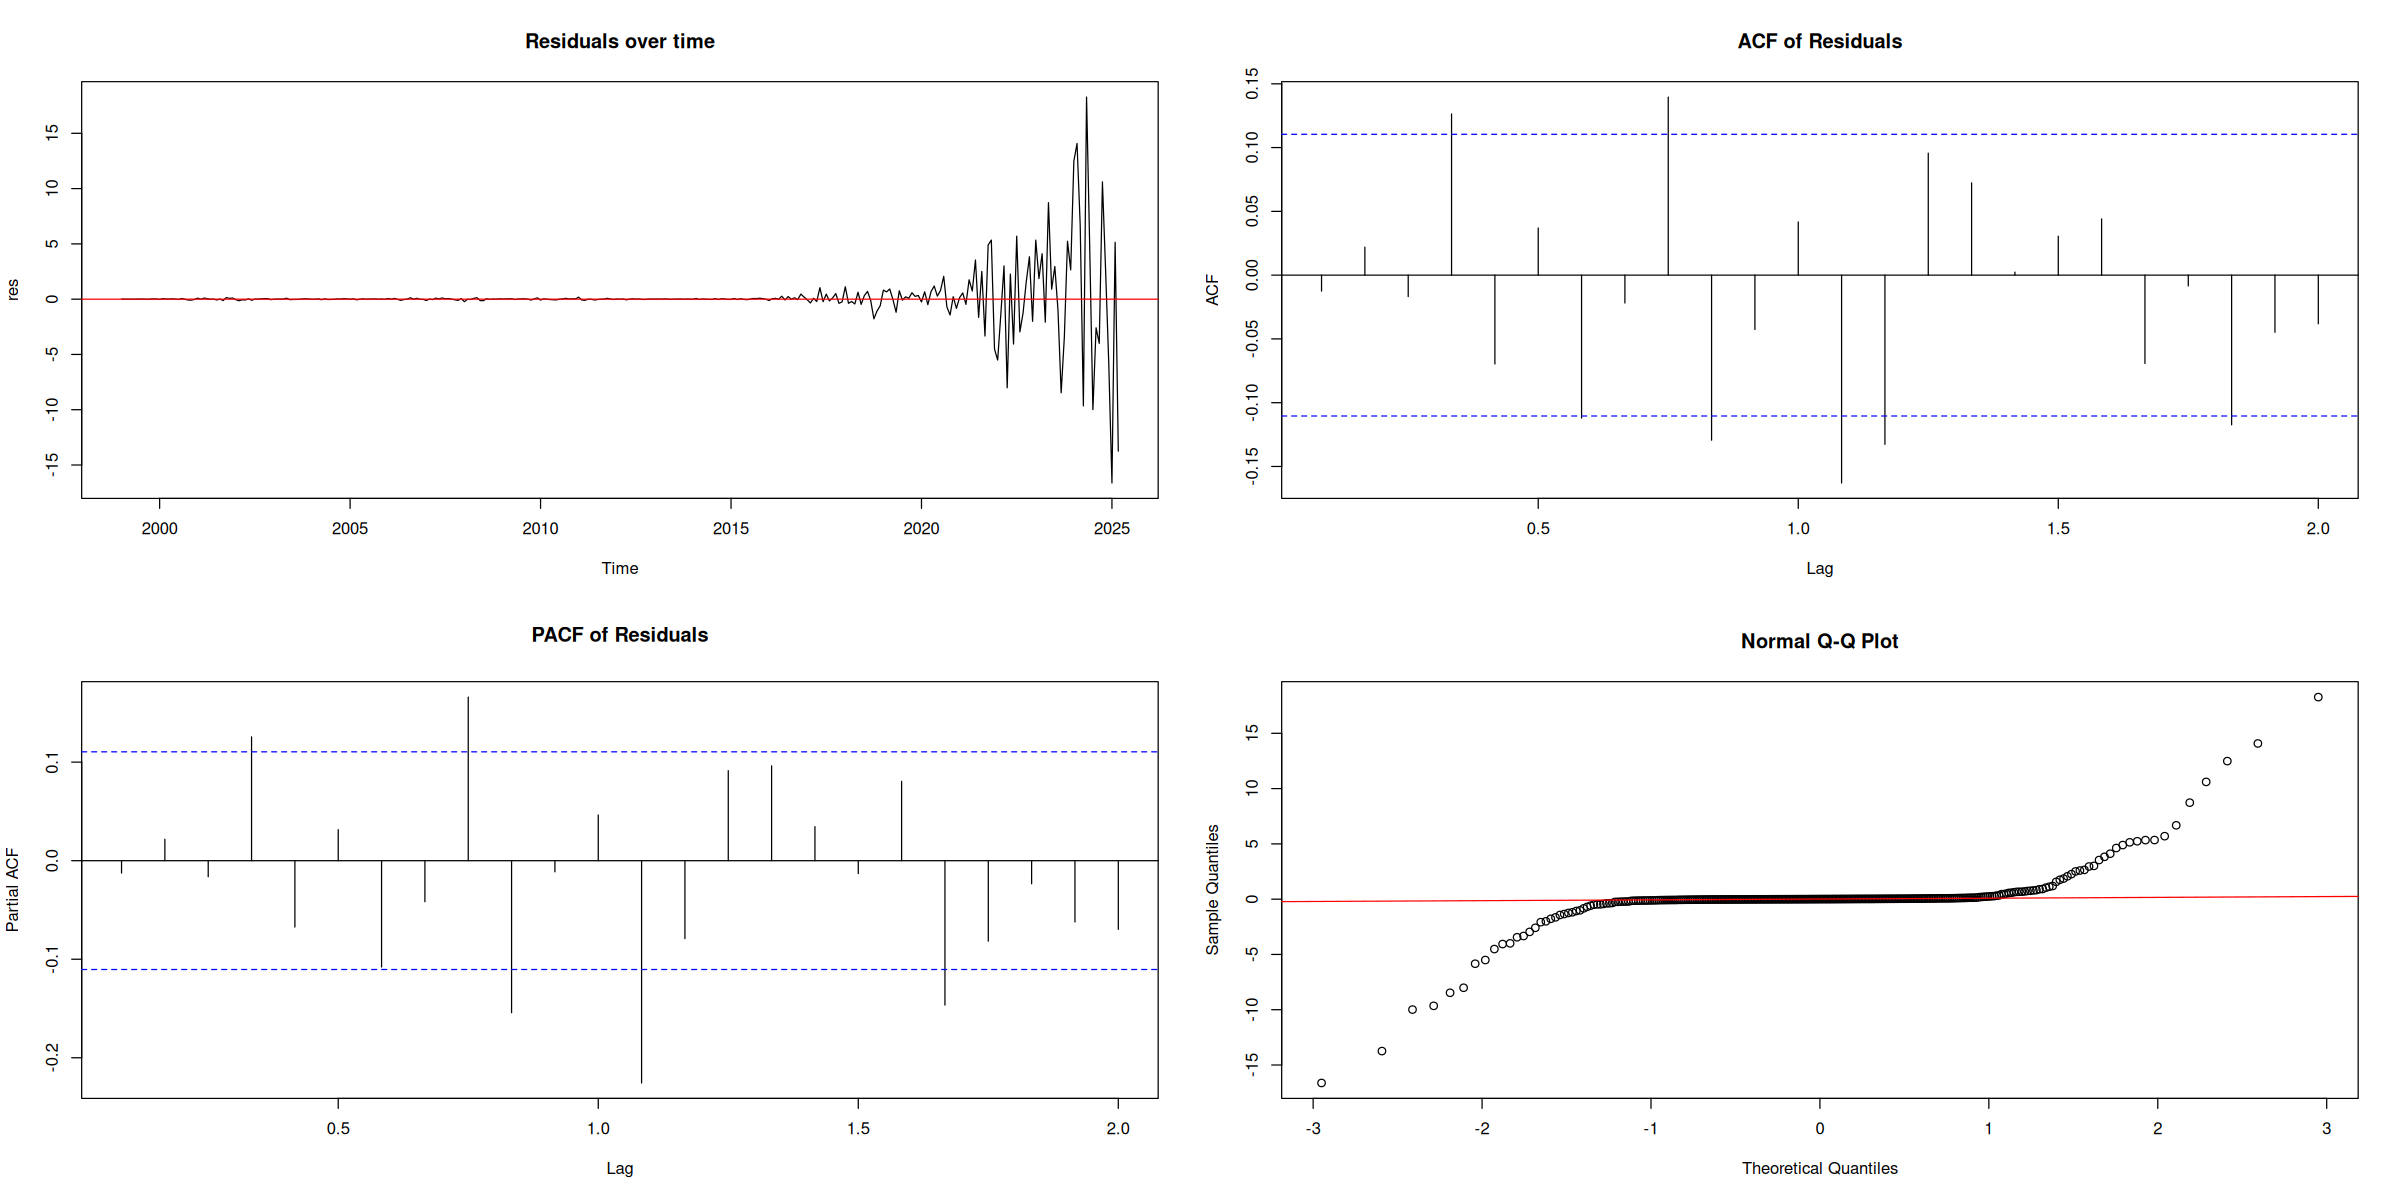


5. Summary of Diagnostic Tests:
-----------------------------------
Normality:        FAIL 
Independence:     PASS 
Homoskedasticity: FAIL 
Randomness:       FAIL 
-----------------------------------

======= DIAGNOSTICS FOR ARIMA(0,1,1) =======

1. Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  res
W = 0.48695, p-value < 2.2e-16

Conclusion: Residuals are NOT normally distributed 

2. Ljung-Box test for autocorrelation:

	Box-Ljung test

data:  res
X-squared = 54.334, df = 12, p-value = 2.381e-07

Conclusion: Residuals are NOT independent (autocorrelation present) 

3. ARCH test for homoskedasticity:

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  res
Chi-squared = 153.15, df = 12, p-value < 2.2e-16

Conclusion: Residuals have NON-constant variance (ARCH effects) 

4. Runs test for randomness:

	Runs Test - Two sided

data:  res > 0
Standardized Runs Statistic = -Inf, p-value < 2.2e-16

Conclusion: Residuals are NOT random 


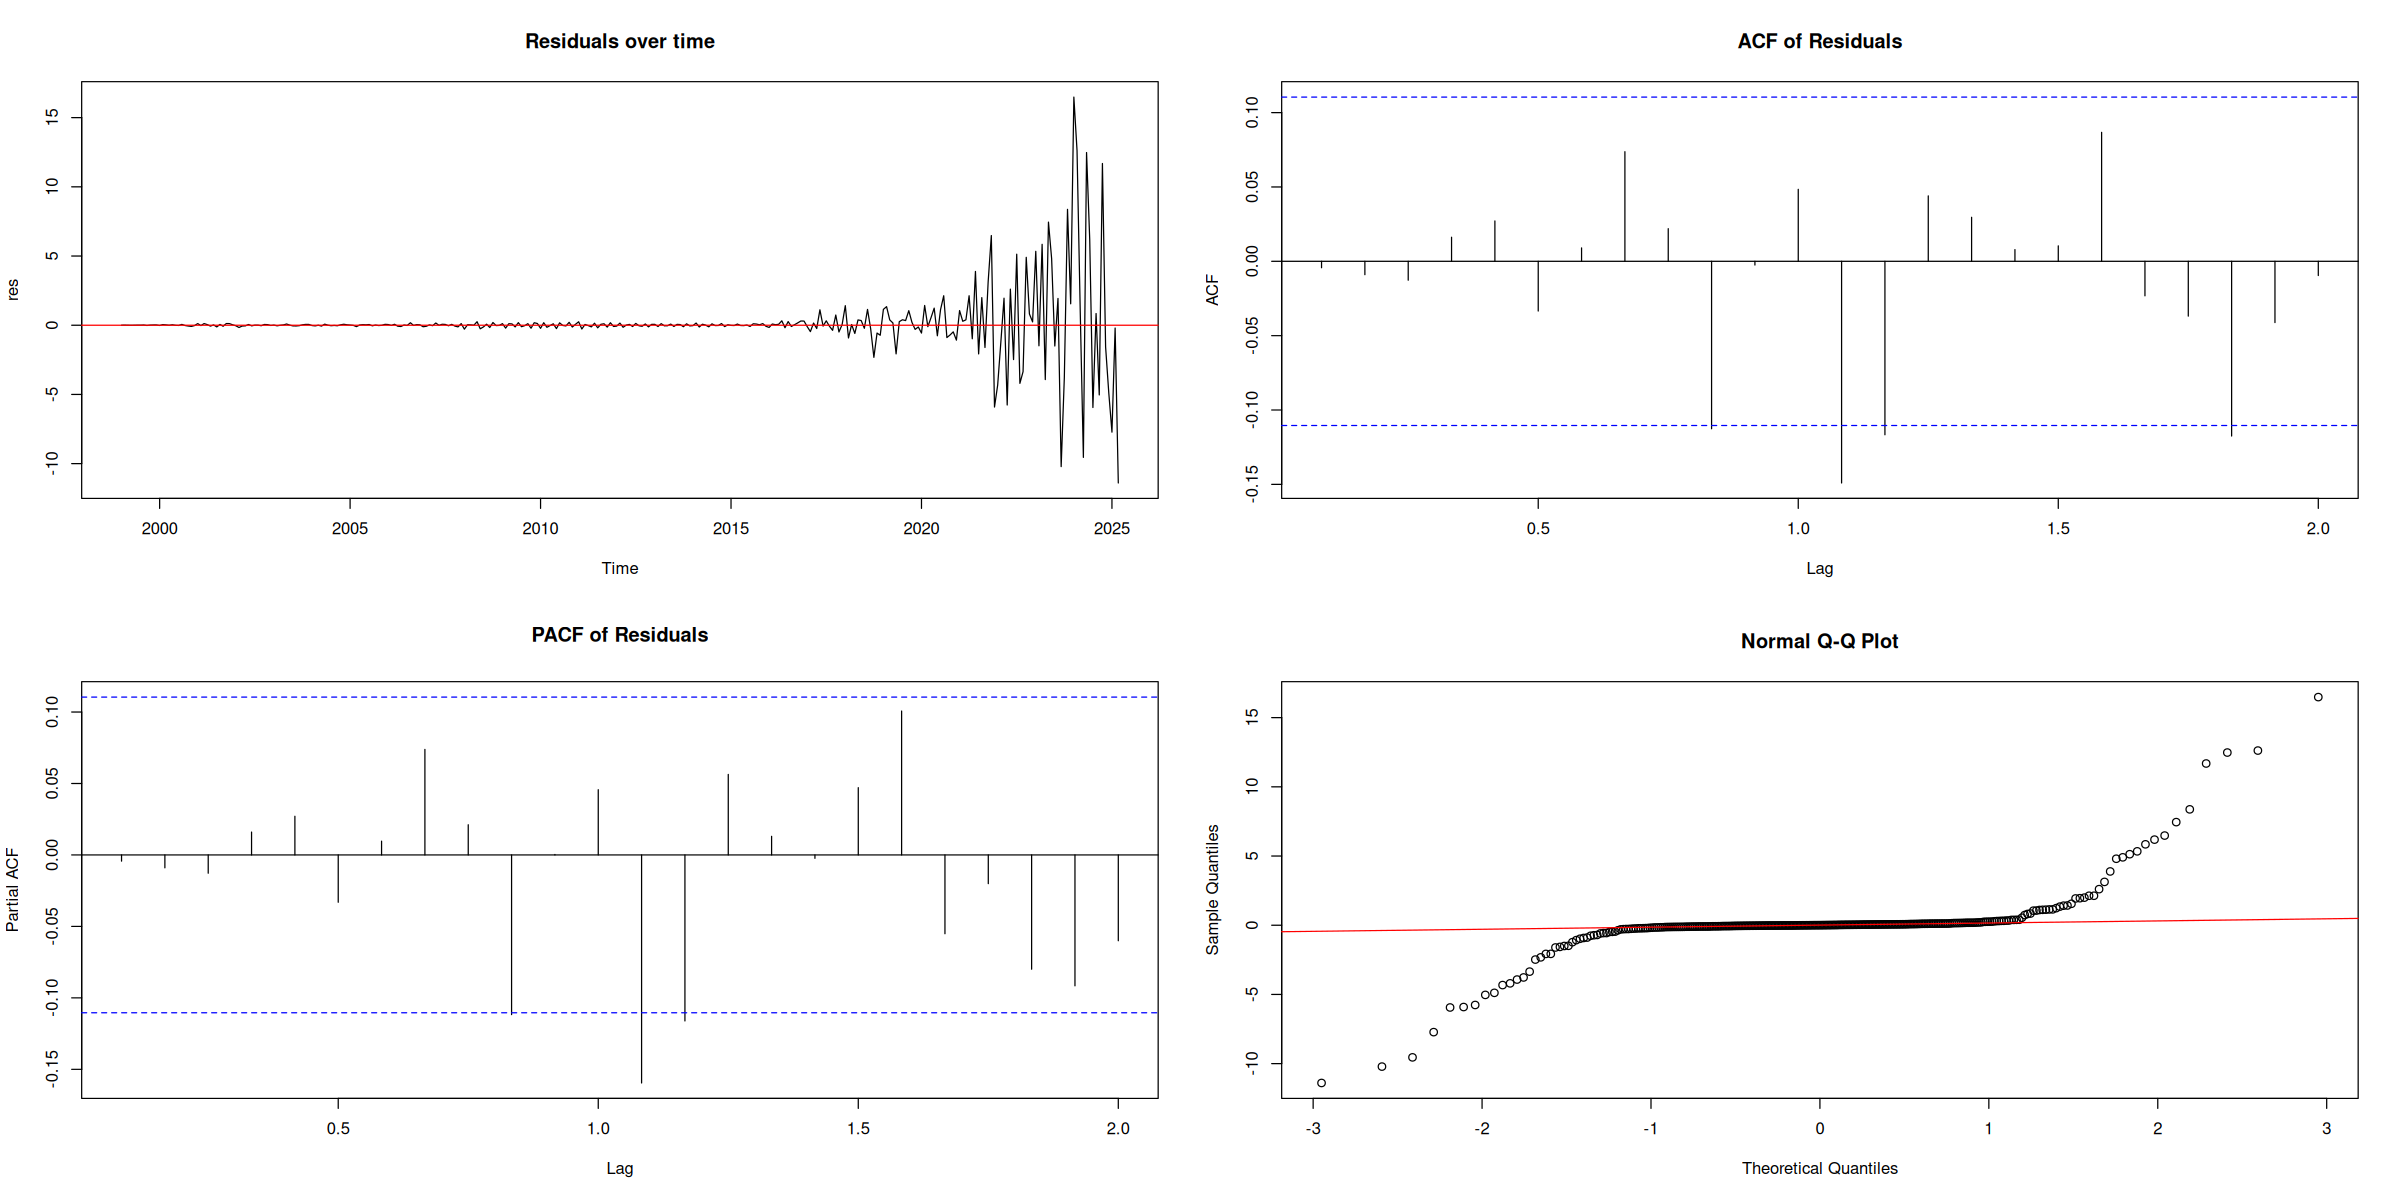


5. Summary of Diagnostic Tests:
-----------------------------------
Normality:        FAIL 
Independence:     FAIL 
Homoskedasticity: FAIL 
Randomness:       FAIL 
-----------------------------------

======= DIAGNOSTICS FOR ARIMA(4,1,4) =======

1. Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  res
W = 0.53534, p-value < 2.2e-16

Conclusion: Residuals are NOT normally distributed 

2. Ljung-Box test for autocorrelation:

	Box-Ljung test

data:  res
X-squared = 10.179, df = 12, p-value = 0.6003

Conclusion: Residuals are independent (no autocorrelation) 

3. ARCH test for homoskedasticity:

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  res
Chi-squared = 163.82, df = 12, p-value < 2.2e-16

Conclusion: Residuals have NON-constant variance (ARCH effects) 

4. Runs test for randomness:

	Runs Test - Two sided

data:  res > 0
Standardized Runs Statistic = -Inf, p-value < 2.2e-16

Conclusion: Residuals are NOT random 


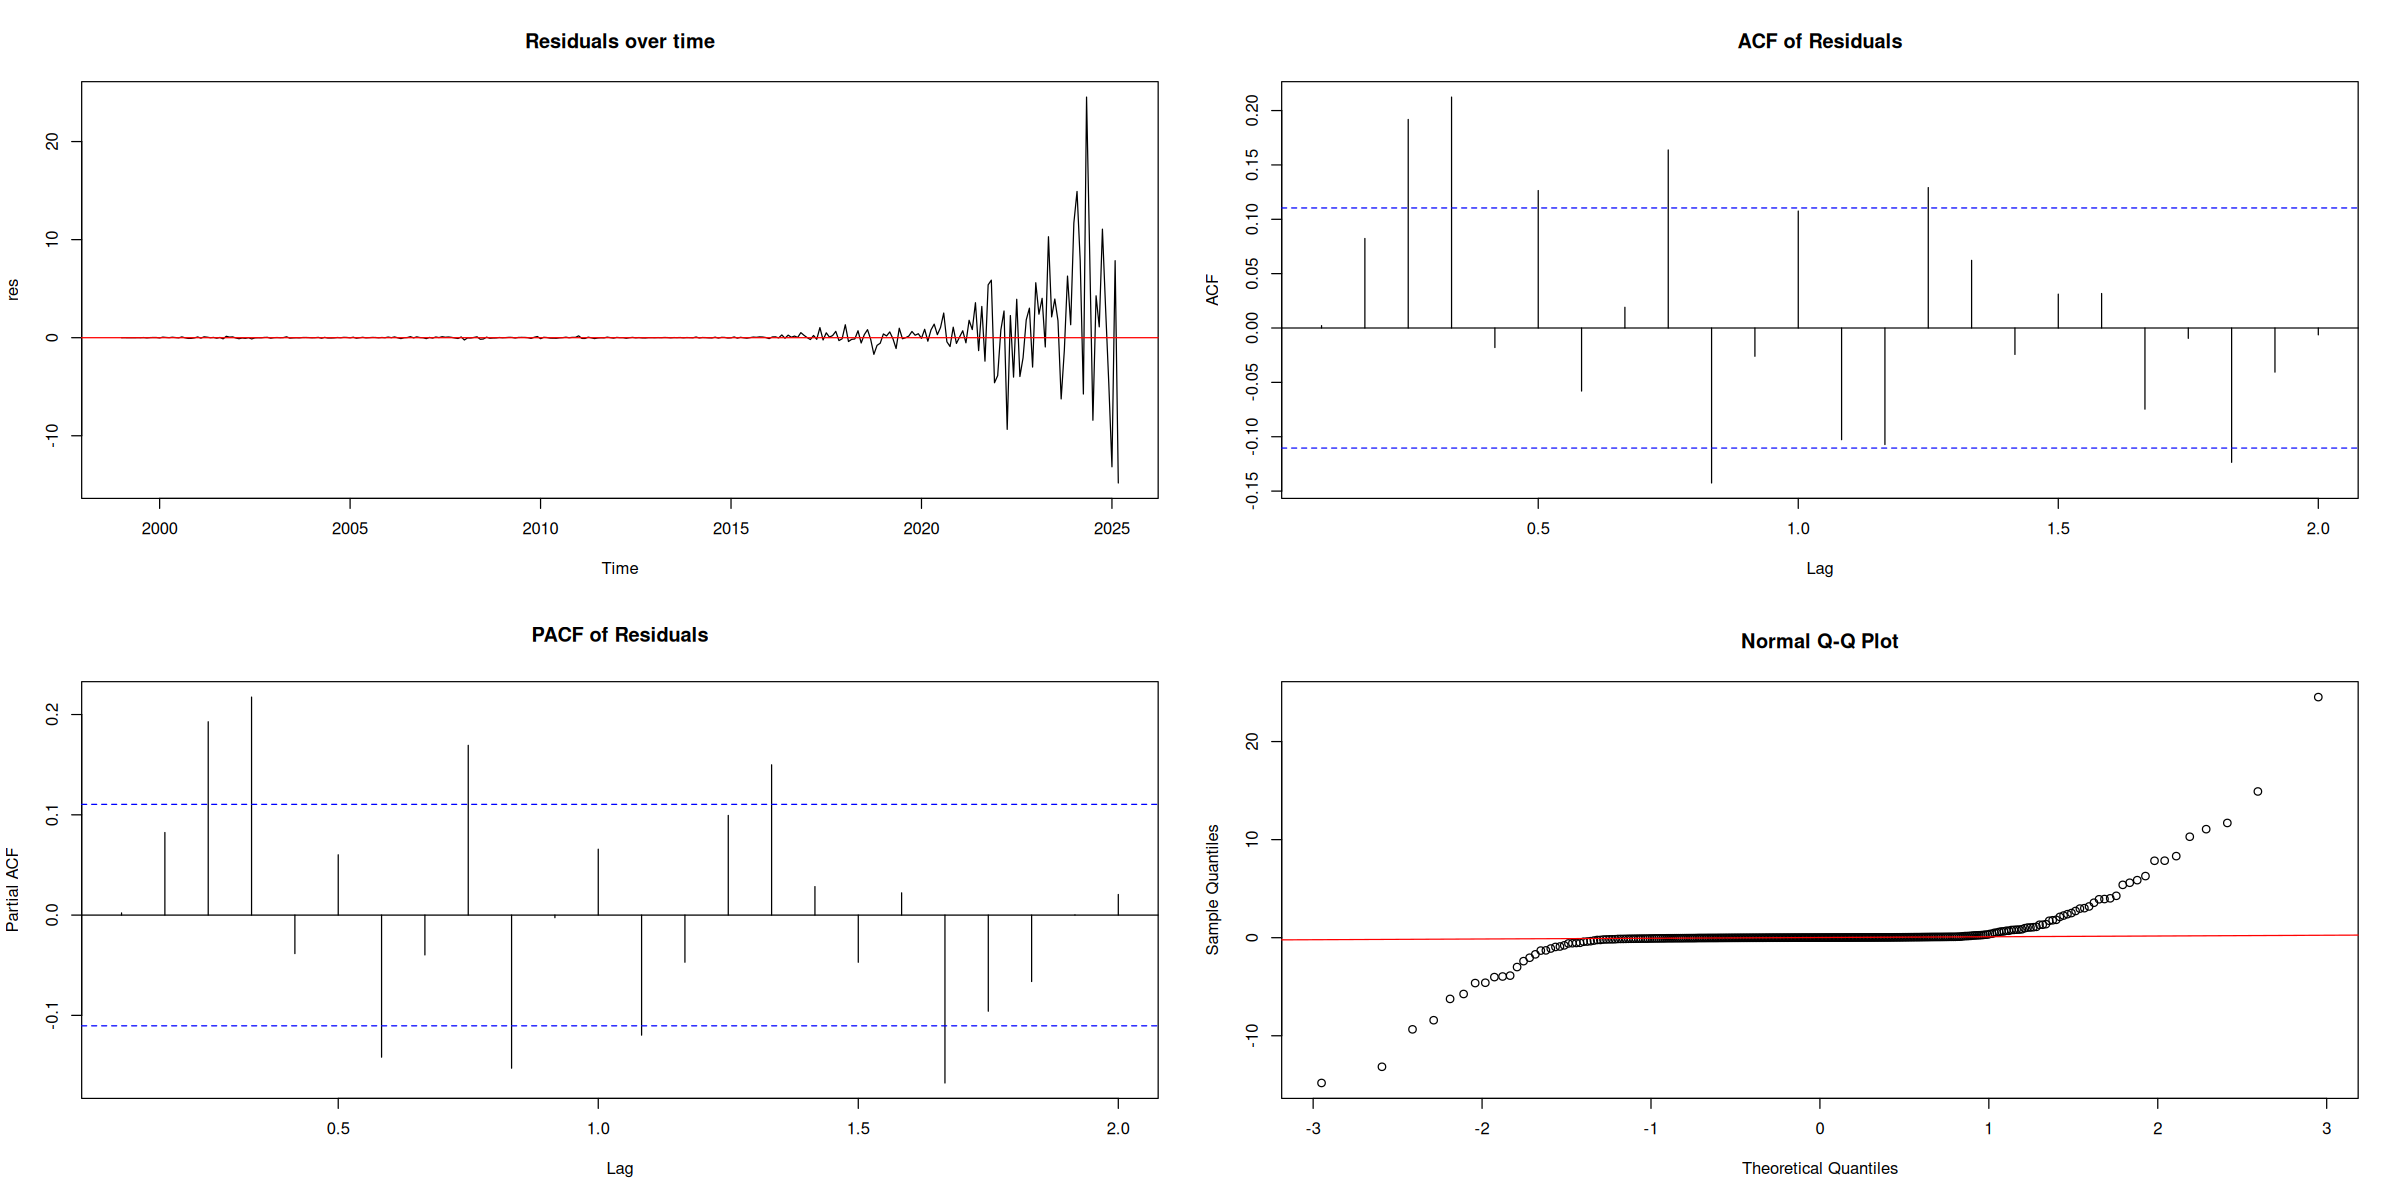


5. Summary of Diagnostic Tests:
-----------------------------------
Normality:        FAIL 
Independence:     PASS 
Homoskedasticity: FAIL 
Randomness:       FAIL 
-----------------------------------

===== COMPARISON OF ALL MODELS =====


|Model        | RMSE_forecast|Normality |Independence |Homoskedasticity |Randomness |
|:------------|-------------:|:---------|:------------|:----------------|:----------|
|ARIMA(3,1,1) |         13.33|FAIL      |FAIL         |FAIL             |FAIL       |
|ARIMA(6,1,4) |         24.53|FAIL      |PASS         |FAIL             |FAIL       |
|ARIMA(0,1,1) |         30.27|FAIL      |FAIL         |FAIL             |FAIL       |
|ARIMA(4,1,4) |         39.20|FAIL      |PASS         |FAIL             |FAIL       |


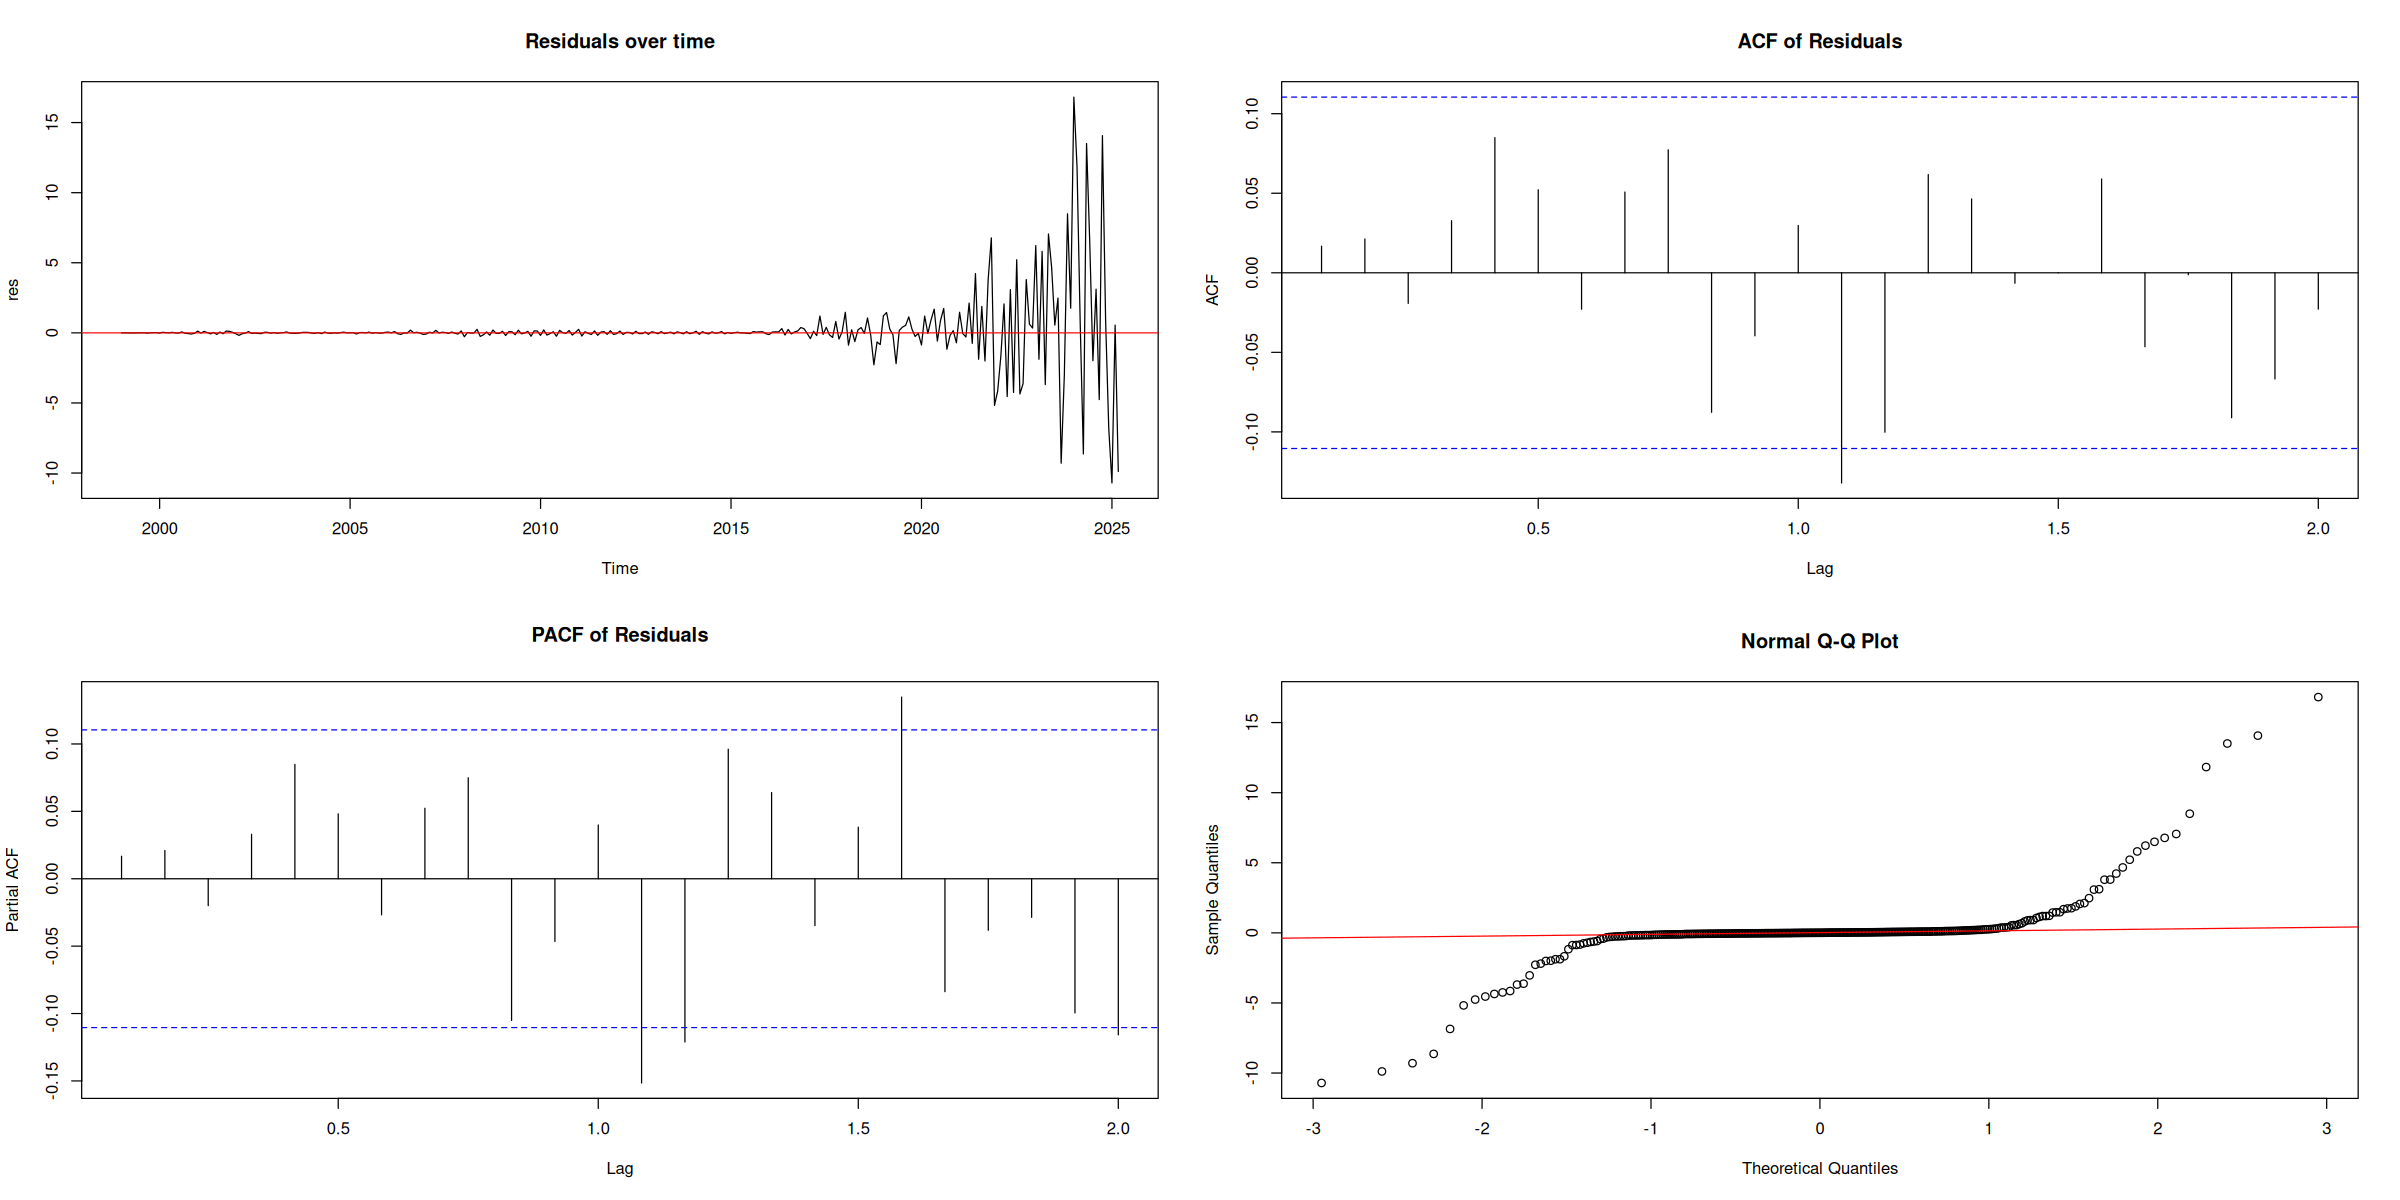

In [49]:
par(bg = "white")
# Function to run diagnostics on an ARIMA model
run_model_diagnostics <- function(p, d, q, data, model_name) {
  cat("\n======= DIAGNOSTICS FOR", model_name, "=======\n")
  
  # Fit model
  model <- Arima(data, order = c(p, d, q))
  
  # Get residuals
  res <- residuals(model)
  
  # Normality test
  shapiro_test <- shapiro.test(res)
  cat("\n1. Shapiro-Wilk test for normality:\n")
  print(shapiro_test)
  norm_ok <- shapiro_test$p.value > 0.05
  cat("Conclusion: Residuals are", ifelse(norm_ok, "normally distributed", "NOT normally distributed"), "\n")
  
  # Independence test (Ljung-Box)
  lb_test <- Box.test(res, lag = 12, type = "Ljung-Box")
  cat("\n2. Ljung-Box test for autocorrelation:\n")
  print(lb_test)
  indep_ok <- lb_test$p.value > 0.05
  cat("Conclusion: Residuals are", ifelse(indep_ok, "independent (no autocorrelation)", "NOT independent (autocorrelation present)"), "\n")
  
  # ARCH test
  arch_test <- ArchTest(res, lags = 12)
  cat("\n3. ARCH test for homoskedasticity:\n")
  print(arch_test)
  homo_ok <- arch_test$p.value > 0.05
  cat("Conclusion: Residuals have", ifelse(homo_ok, "constant variance", "NON-constant variance (ARCH effects)"), "\n")
  
  # Runs test
  runs_test <- runs.test(res > 0)
  cat("\n4. Runs test for randomness:\n")
  print(runs_test)
  random_ok <- runs_test$p.value > 0.05
  cat("Conclusion: Residuals are", ifelse(random_ok, "random", "NOT random"), "\n")
  
  # Plot residual diagnostics
  par(mfrow=c(2,2))
  plot(res, main="Residuals over time")
  abline(h=0, col="red")
  acf(res, main="ACF of Residuals") 
  pacf(res, main="PACF of Residuals")
  qqnorm(res)
  qqline(res, col="red")
  par(mfrow=c(1,1))
  
  # Summary table
  cat("\n5. Summary of Diagnostic Tests:\n")
  cat("-----------------------------------\n")
  cat("Normality:       ", ifelse(norm_ok, "PASS", "FAIL"), "\n")
  cat("Independence:    ", ifelse(indep_ok, "PASS", "FAIL"), "\n")
  cat("Homoskedasticity:", ifelse(homo_ok, "PASS", "FAIL"), "\n")
  cat("Randomness:      ", ifelse(random_ok, "PASS", "FAIL"), "\n")
  cat("-----------------------------------\n")
  
  return(model)
}

# Run diagnostics on each model
model1 <- run_model_diagnostics(3, 1, 1, monthly_ts, "ARIMA(3,1,1)")
model2 <- run_model_diagnostics(6, 1, 4, monthly_ts, "ARIMA(6,1,4)")
model3 <- run_model_diagnostics(0, 1, 1, monthly_ts, "ARIMA(0,1,1)")
model4 <- run_model_diagnostics(4, 1, 4, monthly_ts, "ARIMA(4,1,4)")

# Create a summary comparison table
model_comparison <- data.frame(
  Model = c("ARIMA(3,1,1)", "ARIMA(6,1,4)", "ARIMA(0,1,1)", "ARIMA(4,1,4)"),
  RMSE_forecast = c(13.33, 24.53, 30.27, 39.20),
  Normality = c(
    shapiro.test(residuals(model1))$p.value > 0.05,
    shapiro.test(residuals(model2))$p.value > 0.05,
    shapiro.test(residuals(model3))$p.value > 0.05,
    shapiro.test(residuals(model4))$p.value > 0.05
  ),
  Independence = c(
    Box.test(residuals(model1), lag=12, type="Ljung-Box")$p.value > 0.05,
    Box.test(residuals(model2), lag=12, type="Ljung-Box")$p.value > 0.05,
    Box.test(residuals(model3), lag=12, type="Ljung-Box")$p.value > 0.05,
    Box.test(residuals(model4), lag=12, type="Ljung-Box")$p.value > 0.05
  ),
  Homoskedasticity = c(
    ArchTest(residuals(model1), lags=12)$p.value > 0.05,
    ArchTest(residuals(model2), lags=12)$p.value > 0.05,
    ArchTest(residuals(model3), lags=12)$p.value > 0.05,
    ArchTest(residuals(model4), lags=12)$p.value > 0.05
  ),
  Randomness = c(
    runs.test(residuals(model1) > 0)$p.value > 0.05,
    runs.test(residuals(model2) > 0)$p.value > 0.05,
    runs.test(residuals(model3) > 0)$p.value > 0.05,
    runs.test(residuals(model4) > 0)$p.value > 0.05
  )
)

# Convert logical values to "PASS"/"FAIL"
model_comparison$Normality <- ifelse(model_comparison$Normality, "PASS", "FAIL")
model_comparison$Independence <- ifelse(model_comparison$Independence, "PASS", "FAIL")
model_comparison$Homoskedasticity <- ifelse(model_comparison$Homoskedasticity, "PASS", "FAIL")
model_comparison$Randomness <- ifelse(model_comparison$Randomness, "PASS", "FAIL")

# Display comparison table
cat("\n===== COMPARISON OF ALL MODELS =====\n")
print(kable(model_comparison))